In [ ]:
!pip install dill nltk matplotlib seaborn scikit-learn spacy

In [ ]:
!pip install tensorflow_hub tensorflow

In [ ]:
!pip install numpy

In [1]:
import pandas as pd
import numpy as np
import torch
import os
import dill
import glob, csv
import nltk
from nltk.stem import WordNetLemmatizer
nltk.download('wordnet')
nltk.download('punkt') # Download this as this allows you to tokenize words in a string.
lemmatizer = WordNetLemmatizer()


import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
import numpy as np
import re
import string
import seaborn as sns
from sklearn.preprocessing import StandardScaler

[nltk_data] Downloading package wordnet to
[nltk_data]     /home/catking14/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to /home/catking14/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


Convert CSV to Dataframe

In [ ]:
#convert csv to dataframe
train_dataframe = pd.read_csv("/content/drive/MyDrive/Deep-Learning-based-Authorship-Identification/data/mega_train.csv")

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
test_dataframe = pd.read_csv("/content/drive/MyDrive/Deep-Learning-based-Authorship-Identification/data/mega_test.csv")

In [ ]:
new_csv = []
skip = True

with open("/content/drive/MyDrive/Deep-Learning-based-Authorship-Identification/data/attack_train.csv", "r") as attack_csv:
  content = csv.reader(attack_csv)

  for row in content:
    if skip == True:
      skip = False
      continue

    # print(row[0])
    str_temp = re.findall(r"'(.*?)'|\"(.*?)\"", row[0])
    final_str = []

    for words in str_temp:
      if(words[0] == ""):
        final_str.append(words[1])
      else:
        final_str.append(words[0])
    new_csv.append([" ".join(final_str), row[1]])
    # break

with open("/content/drive/MyDrive/Deep-Learning-based-Authorship-Identification/data/attack_train_str.csv", "w") as attack_str:
  writer = csv.writer(attack_str)
  writer.writerow(["text", "Author_num"])

  for article in new_csv:
    writer.writerow(article)

In [ ]:
train_dataframe.head()

,index,text,Author
0,3225,Treasury Secretary Robert Rubin goes to Capito...,AaronPressman
1,744,U.S. banks will be able to significantly incre...,AaronPressman
2,737,Supreme Court justices Wednesday sharply quest...,AaronPressman
3,740,"Fast running out of options, federal credit un...",AaronPressman
4,3241,The U.S. Commerce Department showed an unexpec...,AaronPressman


In [ ]:
test_dataframe.head()

,index,text,Author,hopeful_test
0,8,Britain's Ladbroke Group Plc Monday concluded ...,SimonCowell,1
1,10,Scottish Amicable on Thursday asked for firm o...,SimonCowell,1
2,15,Scottish Amicable's plans to float on the stoc...,SimonCowell,1
3,17,The head of the Securities and Investments Boa...,SimonCowell,1
4,20,Britain's Britannic Assurance declared on Tues...,SimonCowell,1


 Create new column with author number mappings for ML

In [ ]:
# create new col with author number mappings for ML
auth_sort = sorted(train_dataframe['Author'].unique())
dictOfAuthors = { i : auth_sort[i] for i in range(0, len(auth_sort) ) }
swap_dict = {value:key for key, value in dictOfAuthors.items()}
train_dataframe['Author_num'] = train_dataframe['Author'].map(swap_dict)

In [ ]:
# create new col with author number mappings for ML
auth_sort = sorted(test_dataframe['Author'].unique())
dictOfAuthors = { i : auth_sort[i] for i in range(0, len(auth_sort) ) }
swap_dict = {value:key for key, value in dictOfAuthors.items()}
test_dataframe['Author_num'] = test_dataframe['Author'].map(swap_dict)

In [ ]:
train_dataframe.head()

,index,text,Author,Author_num
0,3225,Treasury Secretary Robert Rubin goes to Capito...,AaronPressman,0
1,744,U.S. banks will be able to significantly incre...,AaronPressman,0
2,737,Supreme Court justices Wednesday sharply quest...,AaronPressman,0
3,740,"Fast running out of options, federal credit un...",AaronPressman,0
4,3241,The U.S. Commerce Department showed an unexpec...,AaronPressman,0


In [ ]:
test_dataframe.head()

,index,text,Author,hopeful_test,Author_num
0,8,Britain's Ladbroke Group Plc Monday concluded ...,SimonCowell,1,44
1,10,Scottish Amicable on Thursday asked for firm o...,SimonCowell,1,44
2,15,Scottish Amicable's plans to float on the stoc...,SimonCowell,1,44
3,17,The head of the Securities and Investments Boa...,SimonCowell,1,44
4,20,Britain's Britannic Assurance declared on Tues...,SimonCowell,1,44


In [ ]:
# only left text(article) in dataframe
test_dataframe = test_dataframe.drop(columns='Author')
# train_dataframe = train_dataframe.drop(columns='Author')
# train_dataframe = train_dataframe.drop(columns='index')
test_dataframe = test_dataframe.drop(columns='index')
test_dataframe = test_dataframe.drop(columns='hopeful_test')

In [ ]:
# check out excerpted data
test_dataframe.head()

,text,Author_num
0,Britain's Ladbroke Group Plc Monday concluded ...,44
1,Scottish Amicable on Thursday asked for firm o...,44
2,Scottish Amicable's plans to float on the stoc...,44
3,The head of the Securities and Investments Boa...,44
4,Britain's Britannic Assurance declared on Tues...,44


In [ ]:
train_dataframe.head()

,text,Author_num
0,Treasury Secretary Robert Rubin goes to Capito...,0
1,U.S. banks will be able to significantly incre...,0
2,Supreme Court justices Wednesday sharply quest...,0
3,"Fast running out of options, federal credit un...",0
4,The U.S. Commerce Department showed an unexpec...,0


In [ ]:
list_to_choose_train = train_dataframe.text.apply(lambda x : len(x)) > 0
train_df_article = train_dataframe[list_to_choose_train]

In [ ]:
list_to_choose_test = test_dataframe.text.apply(lambda x : len(x)) > 0
test_df_article = test_dataframe[list_to_choose_test]

In [ ]:
train_df_article.to_csv(r'/content/drive/MyDrive/Deep-Learning-based-Authorship-Identification/data/train.csv', index = False)

In [ ]:
test_df_article.to_csv(r'/content/drive/MyDrive/Deep-Learning-based-Authorship-Identification/data/test_v3.csv', index = False)

To use *torchtext* here, we might need to re-install old version of it.

Here we use torchtext 0.6.0.

In [4]:
# We have to use old version of torchtext to use data.Field attribute
!pip install torchtext==0.6.0

/bin/bash: warning: setlocale: LC_ALL: cannot change locale (en_US.UTF-8)
Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 64.2/64.2 kB 1.6 MB/s eta 0:00:00a 0:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 13.2 MB/s eta 0:00:00 0:00:01

[notice] A new release of pip is available: 23.2.1 -> 23.3.2
[notice] To update, run: python -m pip install --upgrade pip


In [5]:
!python -m spacy download en_core_web_sm

/bin/bash: warning: setlocale: LC_ALL: cannot change locale (en_US.UTF-8)
Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.8/12.8 MB 81.6 MB/s eta 0:00:00 0:00:01

[notice] A new release of pip is available: 23.2.1 -> 23.3.2
[notice] To update, run: python -m pip install --upgrade pip
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')


In [2]:
#import torch
#import spacy
#nlp = spacy.load("en_core_web_sm")
from torchtext import data
TEXT = data.Field(sequential=True, tokenize="spacy", tokenizer_language="en_core_web_sm", lower=True, include_lengths=True) # new tokenizer_language to fit new model
SCORE = data.Field(sequential=False, use_vocab=False)

2023-12-24 21:30:35.451463: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2023-12-24 21:30:35.451581: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2023-12-24 21:30:35.555861: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-12-24 21:30:35.618330: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


Utilizing Datafields

In [3]:
datafields = [("text", TEXT),
              ("Author_num", SCORE)]

train= data.TabularDataset(
    path='./data/train.csv',
    format='csv',fields=datafields,skip_header = True)

val = data.TabularDataset(
    path='./data/test.csv',
    format='csv',fields=datafields,skip_header = True)


# take only partial example
# train_examples = [example for example in train]
# train_subset = train_examples[:1]
# train = data.Dataset(train_subset, fields=datafields)

In [ ]:
ex1 = [['who', 'is', 'threr'], 1]
ex2 = data.Example.fromlist(ex1, fields=datafields)
print(ex2.text)
print(ex2.Author_num)
print(train[0].text)

In [4]:
from torchtext import vocab
from torchtext.vocab import GloVe
TEXT.build_vocab(train, val, min_freq = 3, vectors=GloVe(name='6B', dim=100))

**Iterators**

In [5]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu') # choose device according to hardware support
BATCH_SIZE = 64
# train_iterator = data.BucketIterator(
#     train,
#     batch_size = BATCH_SIZE,
#     sort_key = lambda x: len(x.text),
#     sort_within_batch = True,
#     repeat=False,
#     shuffle=True,
#     device = device)

val_iterator = data.BucketIterator(
    val,
    batch_size = BATCH_SIZE,
    sort=False,
    sort_key = lambda x: len(x.text),
    sort_within_batch = True,
    repeat=False,
    shuffle=False,
    device = device)


# print(train.examples[0].text)
# print(val_iterator.data()[0].text)

# for batch in val_iterator:
#   c, cl = batch.text
#   print(c[0])
#   break


In [6]:
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
import random
import numpy as np
import matplotlib
import pandas as pd
import dill
import random
import torch.optim as optim
import matplotlib.pyplot as plt

**Network Architecture**

In [7]:
class AuthorClassifier(nn.Module):

    def __init__(self, mode, output_size, hidden_size, vocab_size, embedding_length, word_embeddings):
      super(AuthorClassifier, self).__init__()

      if mode not in ['rnn', 'lstm', 'gru', 'bilstm']:
        raise ValueError("Choose a mode from - rnn / lstm / gru / bilstm")

      self.mode = mode
      self.output_size = output_size
      self.hidden_size = hidden_size
      self.vocab_size = vocab_size
      self.embedding_length = embedding_length
      self.embedding = nn.Embedding(self.vocab_size,self.embedding_length)
      self.embedding.weight = nn.Parameter(word_embeddings,requires_grad = True)  # True to keep gradient



      if self.mode == 'rnn':
        self.network = nn.RNN(self.embedding_length,self.hidden_size)
      elif self.mode == 'lstm':
        self.network = nn.LSTM(self.embedding_length,self.hidden_size)
      elif self.mode == 'gru':
        self.network = nn.GRU(self.embedding_length,self.hidden_size)
      elif self.mode == 'bilstm':
        self.network = nn.LSTM(self.embedding_length,self.hidden_size,bidirectional = True)


      self.fclayer = nn.Linear(self.hidden_size,self.output_size)


    def forward(self, text, text_lengths):
      text_embeddings = self.embedding(text)
      pack_sequence = nn.utils.rnn.pack_padded_sequence(text_embeddings,text_lengths.cpu()) # lengths.cpu() for matching new input format

      if self.mode in ('lstm','bilstm'):
        a,(hidden,cell) = self.network(pack_sequence)
        if self.mode == 'bilstm':
          hidden = hidden[0,:,:]+ hidden[1,:,:]
      else:
        a,hidden = self.network(pack_sequence)
      hidden = hidden.squeeze(0)
      pred = self.fclayer(hidden)
      return pred

**Training and testing models**

In [8]:
import sklearn
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import ConfusionMatrixDisplay  # new version of plot_confusion_matrix

# grad_cache = []
def store_grad(grad):
  grad_cache.append(grad)
  return grad

def train_classifier(model, dataset_iterator, loss_function, optimizer, num_epochs, log = "runs", verbose = False, recurrent = True):
  writer = SummaryWriter(log_dir=log)
  model.train()
  step = 0
  f1score_train = []
  accuracy_train = []
  loss_train = []

#   model.embedding.weight.register_hook(store_grad)
  for epoch in range(num_epochs):
    correct = 0
    total = 0
    total_loss = 0
    f1 = 0
    f1_step = 0

    for batch in dataset_iterator:
      comment, comment_lengths = batch.text
      labels = batch.Author_num

      # print(comment.size())
      # print(labels)

      batch_size = len(labels)
      optimizer.zero_grad()
      output = model(comment, comment_lengths).squeeze(0)
      # model.embedding.weight.retain_grad()

      # vocab_list = TEXT.vocab.itos
      # tmp = []
      # for idx in range(64):
      #   tmp.append(vocab_list[comment[0][idx]])

      # print(tmp)

      # reshape when only one article in training set
      if output.size() == torch.Size([50]):
        output = output.view(1, 50)

      loss = loss_function(output, labels.long())
      loss.backward()
      nn.utils.clip_grad_norm_(model.parameters(),0.5)
      optimizer.step()

      pred = torch.max(output.data,1).indices
      f1 += sklearn.metrics.f1_score((labels.cpu()).numpy(), (pred.cpu()).numpy(),average= 'macro')
      correct += (torch.sum(pred == labels)).item()
      total += len(labels)
      total_loss += loss.item()
      f1_step += 1

      if ((step % 100) == 0):
        writer.add_scalar("Loss/train", total_loss/total, step)
        writer.add_scalar("Acc/train", correct/total, step)
        writer.add_scalar("F1 Score/train", f1/f1_step, step)

      step = step+1
    f1score_train.append(f1/f1_step)
    loss_train.append(total_loss/total)
    accuracy_train.append(correct/total)
    print('---Training statistics---',"Epoch: %s Acc: %s Loss: %s"%(epoch+1, correct/total, total_loss/total),'F1 Score:',f1/f1_step,)

  return loss_train,f1score_train,accuracy_train

def evaluate_classifier(model, dataset_iterator, loss_function, recurrent = True):
  model.eval()

  correct = 0
  total = 0
  total_loss = 0
  overall_pred = []
  overall_label = []
  accuracy_test = []
  loss_test = []
  f1_step = 0
  f1 = 0

  for batch in dataset_iterator:
    comment, comment_lengths = batch.text
    labels = batch.Author_num   # tag of author number
    output = model(comment, comment_lengths).squeeze(0)
    # print(output.data)
    # print(len(output.data))
    # prediction will be the values in each row
    # they represent the possibility(weight) of an article which belongs to jth author(in jth row)

    # print(comment[0], comment_lengths)
    # print(model.embedding(comment[0]))
    # print(dataset_iterator.data())
    # print(len(labels))

    # print(len(model.embedding.weight.grad))
    # model.embedding.weight.grad stores the gradient of each word to it's embedding
    # use TEXT.vocab.stoi to generate dictionary to map token: idx, then use idx to get grad by model.embedding.weight.grad[idx]

    # vocab_list = TEXT.vocab.itos
    # tmp = []
    # for idx in range(64):
    #   tmp.append(vocab_list[comment[0][idx]])

    # print(tmp)

    loss = loss_function(output, labels.long()) # .long means .to(torch.int64)
    pred = torch.max(output.data,1).indices
    correct += (torch.sum(pred == labels)).item()
    total += len(labels)
    total_loss += loss.item()
    ap = pred.cpu()
    a = np.asarray(ap)
    labels = labels.cpu()
    b = np.asarray(labels)
    f1_step += 1
    overall_pred.append(a)
    overall_label.append(b)

  overall_p= [val for sublist in overall_pred for val in sublist]
  overall_l = [val for sublist in overall_label for val in sublist]
  f1ss = sklearn.metrics.f1_score(overall_l,overall_p,average= 'macro')
  accuracy_test.append(correct/total)
  loss_test.append(total_loss/total)
  print("Validation statistics: Acc: %s Loss: %s"%(correct/total, total_loss/total),'F1 Score:',f1ss)
  return overall_pred,overall_label,accuracy_test,f1ss,loss_test

Simularity calculation


In [9]:
import tensorflow_hub as hub
import tensorflow as tf
import numpy as np

In [10]:
similarity_model = hub.load("https://tfhub.dev/google/universal-sentence-encoder/4")

def similarity_cal(sentence1, sentence2):
  # create sentence embedding
  embedding1 = similarity_model([sentence1])[0]
  embedding2 = similarity_model([sentence2])[0]

  # calculate cosine simularity
  cosine_similarity = np.dot(embedding1, embedding2) / (np.linalg.norm(embedding1) * np.linalg.norm(embedding2))
  # print("相似度:", cosine_similarity)

  return cosine_similarity

2023-12-24 21:36:20.545226: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1929] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 31150 MB memory:  -> device: 0, name: Tesla V100-SXM2-32GB, pci bus id: 0000:1b:00.0, compute capability: 7.0


In [ ]:
ok = [2, 3, 1]
print(sorted(ok))
print(ok)

[1, 2, 3]
[2, 3, 1]


#### Import words list from pregenerated TF-IDF word list

In [11]:
words_can_replace = []

with open("./data/tfidf-words-20.csv", "r") as words_list:
    reader = csv.reader(words_list)
    
    for row in reader:
        words_can_replace.append(row[0])
        
print(words_can_replace[0])
print(type(words_can_replace[0]))

farc
<class 'str'>


Crucial word search and replacement generator

In [15]:
import numpy as np
from scipy import spatial
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
from collections import Counter
import math

In [50]:
def create_replacement(documents, example, influence_rank=30, replacement_rank=30, sim_threshold=0.9):
    # Use TF-IDF to find cruical words
    tf_idf_dict = {}

    # Count the number of frequency in an article (TF)
    tf = Counter()
    all_words_count = len(example.text)

    for word in example.text:
        tf[word] += 1

    # Calculate TF for each word
    for word, count in tf.items():
        tf_idf_dict[word] = count / all_words_count     

    # Count articles appeared (IDF)
    df = Counter()
    all_article_count = 1000

    for word in set(example.text):
        for document in documents:
            if word in set(document.text):    # exist in some article
                df[word] += 1

    # Calculate TF for each word
    for word, count in df.items():
        tf_idf_dict[word] *= math.log(all_article_count / (count + 1))     # 1 to prevent division by zero

    to_replace = sorted(tf_idf_dict.keys(), key=lambda x: tf_idf_dict[x], reverse=True)[:influence_rank]
    print(to_replace)
#     print(tf_idf_dict)
    

    
    # The part below is aimed to find top k closest words of a certain word.
    # We use euclidean distance in word embedding to calculate.
    words_in_article = []
    for info in example.text:   # example.text is the input article
        words_in_article.append(vocab_dict[info])
    
    for info in words_can_replace:   # put words from tf-idf in 
        words_in_article.append(vocab_dict[info])

    words_in_article = torch.tensor(words_in_article, dtype=torch.int64)
    words_in_article = words_in_article.to(device)  # move to same device as model
    output = model.embedding(words_in_article)  # get embeddings of words
    np_word_dict = {}

    # create dictionary of word-embedding pair of np.array of embeddings
    for i in range(len(output)):
        li = [float(num) for num in output[i]]
        np_word_dict[vocab_list[words_in_article[i]]] = np.array(li)

#     print(np_word_dict)

    # calculate closest word by euclidean distance in word embedding
    alternatives = None
    final_modified = example.text.copy()
    cut = 0   # decied when to stop modify

    for retired in to_replace:
        try:
            candidates = sorted(np_word_dict.keys(), key=lambda word: spatial.distance.euclidean(np_word_dict[word], np_word_dict[retired]))[1:]  # [0] will always be itself
        except KeyError:  # retired not in np_word_dict embedding table
            continue

        # print(retired)
        sim = 0

        # modified the original article and calculate similarity
        modified = final_modified.copy()

        for attempt in candidates:
            if attempt in words_can_replace:
                    modified[modified.index(retired)] = attempt
                    final_modified = modified
                    cut += 1
                    break

        if cut == replacement_rank:
            break

#         sim = similarity_cal(" ".join(example.text), " ".join(modified))
#         if sim > sim_threshold:
#             final_modified = modified


#     print(final_modified)
#     print(example.text)
#     print(cut)
    print(similarity_cal(" ".join(example.text), " ".join(final_modified)))
    alternatives = data.Example.fromlist([final_modified, example.Author_num], fields=datafields) if final_modified != example.text else None

    return alternatives

# print top 5 word of gradient norm
# def top_influence_words(k):
#   ret = list(grad_dict_sorted.keys())[:k]
#   return ret

# to_replace = top_influence_words(5)

Training for word replacement

This part is used for attacking.

In [51]:
#LSTM based
import matplotlib.pyplot as plt
import seaborn as sns

from torch.utils.tensorboard import SummaryWriter
plt.figure(figsize = (10,10))


output_size = 50
hidden_size = 300
vocab_size = len(TEXT.vocab)
embedding_length = 100
word_embeddings = TEXT.vocab.vectors
num_epochs = 1
mode = 'lstm'

# print(len(word_embeddings), len(TEXT.vocab.itos))
# print(len(word_embeddings[0]))
# print(len(TEXT.vocab))
vocab_dict = TEXT.vocab.stoi
vocab_list = TEXT.vocab.itos
# print(vocab_dict["thursday"])

model = AuthorClassifier(mode, output_size, hidden_size, vocab_size, embedding_length, word_embeddings)
model.load_state_dict(torch.load("./data/baseline.pt"))
model = model.to(device)

# log_dir = 'runs/lstm1'
attack_list = []


for example in val:
    attack_list.append(create_replacement(val.examples, example, influence_rank=60, replacement_rank=60))



['hilton', 'ladbroke', 'gaming', 'george', 'hotels', 'hotel', 'hhc', 'entity', 'worldwide', '32', 'groups', 'agreements', 'deal', 'reuniting', 'resilient', 'downturns', 'summmer', 'hhonors', 'each', 'alliance', "'ll", 'dispel', 'companies', 'longer', 'surrounded', '1964', 'bollenbach', 'capitalise', "'re", 'guests', 'whereby', 'shareholdings', 'together', 'reunification', 'hidden', 'confused', 'signing', 'marketing', 'legal', 'confusion', 'operated', 'cyclical', 'loyalty', 'taking', 'knows', 'feb.', 'involves', 'franchises', 'concluded', 'participation', 'development', 'tie', 'awaited', 'spun', 'driving', '49', 'frequent', 'tens', 'primarily', 'provision']
0.9274994
['scotam', 'abbey', 'scottish', 'bid', 'confidentiality', 'amicable', 'agreements', 'bidders', 'offers', 'saim', 'lloyds', 'proposals', 'policyholders', 'signed', 'prudential', 'scotland', 'amp', 'auction', 'process', 'final', 'recommended', 'firm', 'paper', 'mutual', 'board', 'dutch', 'required', 'interested', 'tabled', 'a

0.9355105
['amelio', 'apple', 'copland', 'murphy', 'quarters', 'scratch', 'foundation', 'improve', 'software', 'windows', 'california', 'solid', 'computer', 'computers', 'operating', 'monterey', 'snafus', 'effort', 'system', 'leapfrog', 'spreadsheets', 'programmers', 'worrisome', 'practically', 'distinguish', 'castle', 'investors', 'macintosh', 'gilbert', 'outperform', 'functions', 'yourself', 'specify', 'cupertino', '1998', 'done', 'abandon', 'unexpected', 'fix', 'product', 'slide', 'code', 'overhaul', 'processing', 'components', 'written', 'minority', 'word', 'fundamental', 'marketplace', 'fixing', 'completely', 'priority', 'competing', 'struggling', 'applications', 'letter', 'until', 'faces', 'closer']
0.8867994
['apple', 'performa', 'anderson', 'loss', 'rating', 'quarter', 'sales', 'amelio', 'computer', 'operating', 'agency', 'debt', 'profitability', 'struggling', 'revenue', 'cents', '$', 'return', 'position', 'goal', 'consumer', '8', 'computers', 'weeks', 'september', '?', 'equale

0.93489105
['watson', 'meps', 'kong', 'hong', 'tung', 'legislature', 'elected', 'evil', 'icj', 'china', 'rights', 'contest', 'democratic', 'kingdom', 'democracy', 'matter', 'european', 'chamber', 'freedoms', 'speak', 'reverts', 'patten', 'united', 'shut', 'views', 'people', 'law', 'fears', 'nations', 'believe', 'parliament', 'replace', 'civil', 'human', 'maxim', 'totalitarianism', 'snuffed', 'technicalities', 'panoply', 'grassroot', 'britain', 'dictatorship', 'amongst', 'replaces', 'hague', 'abolition', 'apology', 'chanted', 'slogans', 'relate', 'honestly', 'council', 'territory', 'parliamentarians', 'triumph', 'legality', 'silent', 'mere', 'apologise', 'defending']
0.95798135
['taiwan', 'taiwanese', 'kong', 'hong', 'facto', 'event', 'basic', 'principle', 'hua', '10th', 'flags', 'chong', 'law', 'handover', 'de', 'nationalist', 'flag', 'mission', 'ten', 'island', 'clear', 'raising', 'glasses', 'clinked', 'laughter', 'artistes', 'regent', 'fronting', 'su', 'flushed', 'redness', 'warrior'

0.96004295
['microsoft', 'windows', 'nt', '95', 'quarter', 'upgrade', 'comparisons', 'tough', 'sales', 'office', 'package', 'owens', 'publicising', 'galvin', 'report', 'release', 'coupons', 'buoy', 'hambrecht', 'quist', 'countervailing', 'owen', 'software', 'incredibly', 'crest', 'ore.', 'impending', 'deferred', 'desktops', 'availability', 'portland', 'analyse', 'surveyed', 'scenario', 'guys', 'rob', 'periods', 'cents', 'corporate', 'ended', 'strong', 'latest', 'earlier', 'period', '54', 'acceptance', 'ongoing', 'revenues', 'tremendous', '48', 'slowdown', 'pcs', 'operating', 'dec.', 'comparison', '97', 'fewer', 'processing', 'system', 'beat']
0.9328875
['microsoft', 'earnings', 'sherlund', 'quarter', 'slower', 'software', 'growth', 'brown', 'cents', 'fiscal', 'revenues', 'multiple', '$', 'beat', 'sales', 'rose', 'windows', 'call', '29', 'computer', 'office', 'strength', '741', '85.50', '87.125', 'oem', '866', 'aloud', 'curiosty', 'directionally', '9.16', 'unearned', '1.013', '651', 'co

0.973275
['industries', 'zheng', 'state', 'enterprises', 'burden', 'reform', 'yuan', 'heavy', 'traditional', 'china', 'firms', 'backward', 'slowly', 'unions', 'losses', 'help', 'military', '68,800', 'haihang', '65.12', '45.7', 'compounding', '11.28', '75.8', 'bankruptcies', 'owned', 'defence', 'social', 'sector', 'cradle', '7.8', 'insolvent', 'impoverished', 'employees', 'industrial', 'snail', 'overstaffed', 'grave', 'fitted', 'proceeded', 'workers', 'lumbering', 'unpaid', 'affects', '17.6', 'inland', 'stricken', 'reached', 'sciences', 'wary', 'newspaper', 'show', 'proceeding', 'decent', 'fund', 'mounting', 'transform', 'relief', 'academy', 'ageing']
0.9642609
['wang', 'founder', 'software', 'publishing', 'entrepreneur', 'university', 'employing', 'chinese', 'turnover', 'computer', 'gates', 'shot', 'personal', 'china', 'firm', 'revolution', 'newspapers', 'decade', 'holds', 'abroad', 'computers', 'microsoft', 'net', 'painstakingly', 'inky', 'stereotypes', 'xuan', 'fonts', 'hk$494.9', 'h

0.9762158
['emi', 'music', 'duffy', 'album', 'interim', 'pounds', 'stuttering', 'demerged', '112.5', '188.4', '1,286p', 'southgate', 'sluggishness', '131.9', '124.6', 'hmv', 'beatles', 'anthology', 'spice', 'girls', 'rentals', 'colin', 'labels', 'polygram', 'boasted', 'releases', 'newcomers', '1=.5970', 'dividend', 'term', 'thorn', '12.7', '15p', 'patchy', 'charts', 'artist', 'division', 'marginally', 'releasing', 'majors', 'warner', 'prince', 'debut', '9.4', 'faltering', 'background', 'layoffs', 'grouping', 'variable', 'growth', 'global', 'diluted', 'triple', 'formerly', 'improvements', 'latin', 'simon', 'nv', 'sterling', 'southeast']
0.94395256
['cellnet', 'vodafone', 'digital', 'subscriber', 'uk', 'orange', 'cellular', 'customers', 'mobile', 'figures', 'securicor', 'creditable', '146,000', '244p', '143,000', '880,000', 'one-2', 'ora.l', '2.5p', 'customer', 'numbers', '2.68', 'novelty', '188p', 'confirming', 'q4', 'cancellations', '4p', 'transferring', 'corresponding', 'reversing', '

0.98118234
['invesco', 'mccullough', 'aim', 'merger', 'management', 'exquisitely', 'shareholders', 'fund', 'deal', 'combined', 'approaches', 'ubs', 'presented', '1.1', 'creating', 'experts', 'brewington', 'thorton', 'overpriced', 'valued', 'cross', 'identities', 'lovell', 'strategists', 'conversely', 'opportunities', 'amvesco', 'brady', 'putnam', 'occurs', 'passive', 'houston', 'forsee', 'hinder', 'lead', 'rather', 'buying', 'prototype', 'timed', 'debt', 'investment', 'correction', 'clash', 'differing', 'downward', '290', 'selling', 'underlined', 'enhance', 'approvals', 'financially', 'bruce', 'excessive', 'francisco', 'dow', 'load', 'concentrated', 'stressed', 'culture', 'exposure']
0.9618074
['governance', 'greenbury', 'skipper', 'directors', 'remuneration', 'norwich', 'melville', 'scrutiny', 'pay', 'outrage', 'corporate', 'simpson', 'perhaps', 'institutional', 'receives', 'ross', 'her', 'packages', 'shareholders', 'row', 'pension', 'water', 'utilities', 'performance', 'pound', 'mana

0.9256606
['b.a.t', 'smoking', 'tobacco', 'broughton', 'litigation', 'pounds', 'affecting', 'rose', 'diseases', 'lung', 'science', 'profits', 'insurance', 'cancer', 'pence', 'dominant', 'nine', 'u.s.', 'claims', 'fo', 'tocacco', '434', 'cairns', 'nyren', 'malden', 'results', 'stockmarket', 'demerging', 'addictive', 'subcontinent', 'servies', '194', '1=.6223', 'industries', '714', '680', 'unsettle', '585', '162', '1130', 'value', 'company', '2.04', '1.87', '1.27', 'profit', 'causes', 'mechanisms', 'eagle', '3.3', 'demerger', 'conclusions', 'cell', 'indian', 'share', 'seven', 'sales', 'lord', 'responding', 'fiercely']
0.96447355
['duty', 'beer', 'whisky', 'excise', 'tobacco', 'brewers', 'clarke', 'bottle', 'budget', 'pint', 'rolling', 'cut', 'stg', 'inflation', 'blra', 'exchequer', 'freeze', 'scotch', 'pack', 'pounds', 'smuggling', 'britain', 'revenue', 'association', 'arguing', 'equivalent', 'europe', '2.0', 'tax', 'cigarettes', 'paid', 'pence', 'letter', 'mainland', 'illegal', 'europea

0.95093864
['eurotunnel', 'debt', 'shareholders', '1.56', 'tunnel', 'banks', 'brings', '225', 'announcement', 'restructuring', 'pounds', 'billion', 'pence', 'channel', 'morton', 'brighter', 'wrestled', 'instructing', '5.8', 'entitling', '113.5', 'reduce', '45.5', '54.5', 'alastair', '10.40', 'interests', 'owes', 'finalise', 'converted', 'subscribe', 'plan', 'company', 'creditor', '14.1', 'simultaneously', 'insolvency', 'crippling', 'ferry', 'ponsolle', '8.7', 'french', 'achievements', 'considerably', 'brink', 'patient', 'syndicate', '3.7', 'before', 'secretive', '13.6', '2003', 'diluted', 'acceptable', 'deal', 'wrangling', 'leaves', 'warrants', 'allow', 'wiping']
0.9657702
['horlick', 'her', 'mgam', 'dmg', 'poach', 'abn', 'deutsche', 'fund', 'resigned', 'team', 'grenfell', 'amro', 'farr', 'reinstatement', 'allegations', 'she', 'reinstated', 'management', 'morgan', 'clients', 'colleagues', 'promoted', 'denied', 'staff', 'affair', 'bank', 'advisers', 'compensation', 'parent', 'manager', 

0.92359513
['mutual', 'national', 'thailand', 'axa', 'tomlinson', 'philippines', 'vietnam', 'a$', 'licence', 'china', 'uap', 'india', 'insurance', 'offices', 'management', 'funds', '7.0', 'asian', 'applied', 'insurer', 'us$', 'application', 'arm', 'fleshed', 'sweating', 'athol', 'lapthorne', 'hk$10', 'reopening', 'acquainted', 'fazed', 'fertile', 'inherits', 'kavourakis', 'hk$1', 'us$7.74', 'wuhan', 'chengdu', 'ihd', 'thai', 'awarding', 'till', 'us$0.75', '=', 'heavyweights', 'everbright', 'aligned', 'finalise', 'managing', 'dalian', 'donated', 'geoff', 'progressively', 'life', 'populous', 'corrects', 'decides', 'assets', 'representation', 'stands']
0.96542513
['pasminco', 'dollar', 'zinc', 'stewart', 'australian', 'profit', 'greenback', 'a$', 'stronger', 'weak', 'tripling', 'quarter', 'subdued', 'suffers', 'impact', 'delivering', 'dragging', 'average', '7.5', 'annual', 'surprised', 'beat', '41', 'dramatically', 'cent', 'metals', 'prices', 'reporting', 'throughout', 'outlook', 'moved',

0.97974247
['gm', 'hargrove', 'uaw', 'strike', 'workers', 'canadian', 'guarantee', 'automaker', 'productive', 'caw', 'outsourcing', 'yokich', 'sharing', 'hourly', 'employment', 'settlement', 'pattern', 'u.s.', '95', 'auto', 'plants', 'basil', 'characterize', 'talks', 'curbing', 'canceled', 'kid', 'plant', 'progress', 'parts', 'resist', 'escalating', 'buzz', 'mcghee', 'picket', 'prolonged', 'during', ' \n', 'having', 'reg', 'overtime', 'shutdowns', 'counterparts', '26,000', 'workforces', 'bargainers', 'sticking', 'walkout', 'limiting', 'idled', 'anybody', 'checks', 'agreement', 'meet', 'exclude', 'principle', '215,000', 'transmission', 'provision', 'negotiators']
0.9494792
['lear', 'borealis', 'automotive', 'interior', 'ab', 'industrier', 'instrument', 'panels', 'maker', 'swedish', 'sweden', 'johnson', 'trim', 'components', 'systems', 'panel', 'door', 'acquired', 'acquisition', 'controls', 'car', 'furthering', 'interiors', 'gothenburg', 'exterior', 'truckmaker', 'scania', 'finnish', 'ne

0.97671485
['magaziner', 'draft', 'internet', 'report', 'privacy', 'policies', 'commerce', 'taxation', 'exports', 'should', 'task', 'headed', 'governments', 'care', 'taxes', 'provide', 'free', 'paper', 'critics', 'online', 'clinton', 'what', 'pursues', 'interagency', 'onerous', 'deliberations', 'hitch', 'echoes', 'disagreeing', 'characterisation', 'solver', 'health', 'consumers', 'push', 'globally', 'censorship', 'unites', 'scrambled', 'evolve', 'administration', 'inhibit', 'researchers', 'jupiter', 'dictate', 'conflicting', 'ideologue', 'security', 'ira', 'merchants', 'encoding', 'cyberspace', 'stating', 'designated', 'vendors', 'force', 'format', 'wholly', 'speeding', 'encryption', 'boost']
0.9326373
['bill', 'goodlatte', 'administration', 'burns', 'encryption', 'republican', 'reintroduce', 'senator', 'export', 'caucus', 'judiciary', 'chair', 'introducing', 'considering', 'night', 'staff', 'committee', 'bills', 'computer', 'legislation', 'technology', 'restrictions', 'clinton', 'co',

0.952252
['land', 'estate', 'panel', 'real', 'proposals', 'slump', 'bubble', 'hashimoto', 'falling', 'prices', 'values', 'japan', 'policy', 'specific', 'review', 'bursting', 'landholdings', 'keiko', 'otsuki', 'holdings', 'securitisation', 'surges', 'reeling', 'assessments', 'landowners', 'called', 'inflated', 'structural', 'ryutaro', 'blocking', 'latter', 'intervention', 'taxation', 'arguing', 'concept', 'plummeted', 'cooperate', 'nobody', 'cope', 'metropolitan', 'development', 'change', 'old', 'smooth', 'proportion', 'encourage', 'emergency', 'balanced', 'promote', 'liquidity', 'solve', 'ubs', 'curb', 'adopted', 'influential', 'promotion', 'fundamental', 'request', 'rapid', 'politicians']
0.9308698
['financial', 'markets', 'bang', 'japan', 'hashimoto', 'banks', 'reforms', 'houses', 'ldp', 'mitsuzuka', 'securities', 'tokyo', 'relevant', 'institutions', 'participants', 'rules', 'liberalisation', ':', 'should', 'trillion', 'yen', '--', 'global', 'reform', 'enter', 'others', 'big', "'", '

0.95839936
['rhie', 'daewoo', 'car', 'cars', 'u.k.', 'uk', 'models', 'servicing', 'likes', 'customer', 'customers', 'strategy', 'britain', 'criticism', 'motors', 'motoring', '18,500', 'mould', 'cleverly', 'dislikes', 'hates', 'hassle', 'aftercare', 'extras', 'vauxhall', 'porsche', 'boxster', 'halfords', 'r&amp;d', 'worthing', 'operation', 'adapting', 'advertise', 'summed', 'salesmen', 'wedding', 'bride', 'airbags', 'encountered', 'penetrated', 'hyundai', 'outmoded', 'launch', 'transferring', 'birmingham', 'carved', 'revamped', 'pet', 'inclusive', 'applicable', 'entrenched', 'saab', 'pioneering', 'j', 'tong', '13,000', 'darling', 'quantity', 'target', 'itself']
0.95767635
['zeneca', 'prostate', 'nolvadex', 'sales', 'reorganisation', 'cancer', 'performance', 'treatment', 'drug', '1.62', 'factored', '1689', 'zestril', 'merck', 'mrk.l', 'prinivil', 'cozaar', 'zoladex', 'casodex', 'arimidex', 'tablet', 'accolate', 'insecticide', 'karate', 'slimmed', '1=.6161', 'stage', 'pounds', 'results', 

0.93593687
['virgin', 'chan', 'via', 'cargo', 'kong', 'hong', 'south', 'africa', 'johannesburg', 'freight', 'london', 'african', 'bound', 'air', 'route', 'airlines', 'singapore', 'dyna', 'ld-3', 'overflying', 'varig', 'emirates', 'dubai', '171', '542', 'westbound', 'abu', 'dhabi', 'brinkley', 'shorter', 'permit', 'bangkok', 'container', 'offering', 'dedicated', 'indirect', 'thinks', 'cathay', 'gulf', 'trans', 'agent', 'flown', 'brazil', 'fax+44', 'october', 'clothing', 'flights', 'ex', 'assistant', 'airways', '7706', '5017', 'amounts', 'tel+44', 'atlantic', 'service', 'flying', 'effectively', 'airline', 'carrier']
0.86086166
['fans', 'behrens', 'airlines', 'air', 'traffic', 'faa', 'navigation', 'equipped', 'space', 'pacific', 'cockpit', 'flight', 'milestone', 'cargo', 'proving', 'cathay', 'reduced', 'technology', '747', 'flights', 'routes', 'boeing', 'russian', 'tokyo', 'aircraft', 'narita', 'cns', 'atm', 'errors', 'ordination', 'workhorse', 'avionics', '400', '171', '542', 'use', 'bur

0.95746326
['points', 'forestry', 'toronto', 'c0.30', 'c$', 'beattie', 'golds', 'gold', 'index', '300', 'stocks', 'closer', 'issues', '10.9', '5193.0', '5248.37', 'meridian', '6.20', 'macmillan', 'bloedel', '106.00', 'traded', 'doak', '481', '310', '20.00', 'rose', 'refuse', 'comex', 'products', 'katherine', '371', 'fertilizer', 'potash', 'saskatchewan', '2.00', 'high', 'bank', 'mms', '4.25', 'psychological', 'pack', 'actives', 'key', 'ignoring', 'climbing', 'outnumbered', 'recovered', 'scotiamcleod', 'transports', 'breaking', 'lows', 'led', 'easing', 'firmer', 'edged', 'oils', 'advancing', 'topped', 'dealings']
0.9334506
['c$', 'oils', '6018', 'petroleums', 'toronto', 'morrison', 'ketchen', '88', 'points', 'rally', 'gaining', 'energy', '16.55', '6001.48', '111.7', '652', '544', '294', '24.10', 'watershed', '6000', '476', 'decliners', '9.95', '0.30', '6.45', '1.17', 'juice', '435', '1.58', '0.75', 'canadian', 'actives', 'canada', 'outnumbered', '14.7', 'stocks', 'scotiamcleod', 'fred',

0.9708497
['ameritech', 'michigan', 'distance', 'local', 'service', 'at&amp;t', 'bells', "o'connell", 'fcc', 'regulators', 'application', 'customers', 'long', 'carrier', 'mci', 'phone', 'law', 'seek', 'opened', 'communications', 'permission', 'corp.', 'offer', 'network', 'calling', 'notebart', 'accelerates', 'sallet', '99.6', 'checklist', 'jonathan', 'public', 'approval', 'midwestern', 'convenience', 'intervened', 'called', 'cleland', 'schwab', 'illinois', 'chapter', 'serves', 'competitive', 'indiana', 'stepping', 'premature', 'ignoring', 'federal', 'provide', 'implementation', 'nynex', 'northeast', 'residential', 'wisconsin', 'hundt', 'reject', 'ray', 'occur', 'opens', 'responded']
0.962066
['gold', 'banks', 'output', 'precious', 'bullion', 'russia', 'domestic', 'metals', 'tonnes', 'procedures', 'abroad', 'dmitry', 'certificates', 'parmeshin', 'sergei', 'bankers', 'financed', 'liberalised', 'export', '130', 'reserves', 'say', 'russian', 'backed', 'bank', 'metal', 'central', 'head', 't

0.9783355
['shougang', 'zhou', 'corruption', 'sentence', 'beifang', 'death', 'parent', 'subsidiaries', 'suspended', 'bi', 'restructuring', 'party', 'detention', 'elite', 'saturday', 'conglomerates', 'handed', 'gradually', 'gave', 'influence', 'china', 'son', 'xinhua', 'communist', 'subsidiary', 'meting', 'sobriquet', 'symbolising', 'wield', 'veneer', 'nepotism', 'zhous', 'commuted', 'discharge', 'appraisal', 'qun', '58,000', '176,000', '1.653', 'former', 'princelings', 'limelight', 'guanwu', 'ruling', 'secretary', 'beijing', 'vulnerability', 'sink', 'swim', '199', 'publicised', 'thrust', 'graft', 'heaviest', 'retaining', 'scourge', 'court', 'february', 'sentencing', 'employ']
0.97744817
['tibet', 'temples', 'dalai', 'monks', 'lama', 'religion', 'socialism', 'newspaper', 'nuns', 'region', 'spent', 'buildings', 'beijing', 'students', 'development', 'needs', 'influence', 'china', 'communist', 'must', 'basic', 'forces', '1,787', 'exceeding', 'uproot', 'precedence', 'holiest', 'westernise',

0.9642391
['it&amp;t', 'australia', 'bayley', 'exports', 'aiia', 'a$', 'barriers', 'apec', 'multinational', 'computers', 'equipment', 'tariff', 'australian', 'asia', ' \n', 'technology', 'fleur', 'lbm', 'telecommunictaions', 'association', 'imports', 'goods', '500', 'unlikely', 'leaders', 'benefit', 'informational', 'stimulate', 'maturity', 'plan', 'export', 'pacific', 'telecommunication', 'endorsed', 'telecommunications', '9.6', 'negligible', 'implications', 'imported', 'computer', 'whereas', 'memory', 'mild', 'observers', 'assess', 'tariffs', 'philippines', 'corporations', 'exporter', 'alcatel', 'alsthom', 'exported', 'demand', 'relative', 'chips', '1800', 'economies', 'ones', '9373', 'trade']
0.90379333
['oil', 'gas', 'baker', 'petroleum', 'a$', 'takeovers', 'sector', 'santos', 'assets', 'nl', 'ltd', 'woodside', 'groups', 'companies', 'overseas', 'australian', 'local', 'eye', 'producers', 'prices', 'targets', 'bid', 'dutch', 'worth', 'hartley', 'poynton', '1.78', 'ampolex', 'clyde',

0.95975196
['lhasa', 'bomb', 'tibet', 'dalai', 'region', 'reward', 'lama', 'manhunt', 'culprits', 'followers', 'anti', 'government', 'terrorist', 'blast', '120,000', 'arrest', 'buddhist', 'exploded', 'god', 'officials', 'himalayan', 'exiled', 'police', 'restive', 'tibetan', 'official', 'unrest', 'security', 'king', 'airport', 'christmas', 'peace', 'outside', 'damage', 'chinese', 'kaifu', 'caused', 'mainly', 'act', 'mobilising', 'ou', 'yangxiang', 'yards', 'muffled', 'whoong', 'hallmarks', 'ammonium', 'nitrate', 'fertiliser', 'erupts', 'sporadically', 'plaque', 'smaller', 'strategic', 'shattering', 'radius', 'motivated', 'brazen', 'searches', 'exiles']
0.9692553
['pei', 'china', 'wto', 'concessions', 'entry', 'status', 'chinese', 'enter', 'wait', 'economy', 'principle', 'barriers', 'membership', 'beijing', 'trade', 'country', 'foreign', 'states', 'developing', 'world', 'body', 'stand', 'liberalisations', 'remarkably', 'admittance', 'gradualling', 'renato', 'ruggiero', 'exclusion', 'talk

0.91459215
['inflation', 'kreidl', 'oecd', '8.7', 'czech', 'dlouhy', 'cnb', 'vladimir', 'result', 'average', 'october', 'prices', 'czechs', 'percent', 'percentage', 'nine', 'unchanged', 'slow', 'achievable', 'expectated', 'coopoeration', 'm2', 'mastrini', 'end', 'maastricht', 'stubbornly', 'supply', '8.9', 'industrialised', '13.2', 'perspective', 'tightening', 'forecast', 'evident', 'patria', 'aided', '8.0', 'below', 'rates', '8.8', 'stem', 'lowering', 'dampen', 'policy', '0.5', 'point', 'domestic', 'slowing', 'encouraged', 'influenced', 'tightened', 'rate', 'statistical', 'clothing', 'consecutive', 'check', 'treaty', 'requirements', 'demand', 'convinced']
0.9622451
['salzmann', 'czech', 'banka', 'senate', 'banking', 'fairness', 'banks', 'komercni', 'transparency', 'kreditni', 'seat', 'bank', 'naivete', 'decency', 'manners', 'jezek', 'risk', 'loan', 'kinds', 'capitalism', 'techniques', 'failures', 'loans', 'bad', 'banker', 'ceska', 'conflict', 'practices', 'management', 'bring', 'clean

0.97033876
['france', 'telecom', 'bon', 'mobistar', 'operator', 'gsm', 'olivetti', 'poland', 'licence', 'mobile', 'networks', 'inauguration', 'firstly', 'thirdly', 'beglian', 'omnitel', 'infostrada', 'negotiations', 'romania', 'bouygues', 'secondly', 'wanted', '2005', 'analogue', 'french', 'telecommunications', 'chirac', 'venture', 'michel', 'entirely', 'belgium', 'excluded', 'impact', 'internationally', 'compensate', 'network', 'group', 'modern', 'ambitions', 'tim', 'italian', 'leads', 'jacques', 'policy', 'eaux', 'railways', 'enjoy', 'latin', 'answer', 'competition', 'briefing', 'generale', 'alliances', 'goals', 'aiming', 'italy', 'international', 'telekom', 'hear', 'des']
0.90990907
['breton', 'bull', 'computer', 'subscribe', 'european', 'restructuring', 'private', 'capital', ' \n', 'increase', 'francs', 'electronics', 'join', 'our', 'descarpentries', 'mckinsey', 'preferably', 'zenith', 'shareholders', 'thierry', 'resell', '306', 'olivetti', 'amounting', 'motorola', 'philips', 'siem

0.9680847
['bis', 'zeman', 'klaus', 'spying', 'devaty', 'ods', 'social', 'accused', 'allegations', 'elections', 'nerve', 'compromising', 'democrats', 'lie', 'imagine', 'lux', 'neck', 'political', 'quit', 'democrat', 'mother', 'fraud', 'struggle', 'senate', 'minister', 'politicians', 'prime', 'his', 'losing', 'supervising', 'temperature', 'destabilise', 'police', 'state', 'lying', 'slanging', 'antagonists', 'anarchist', 'spymaster', 'amidst', 'opposition', 'deputy', 'czech', 'running', 'country', 'stanislav', 'protege', 'coverup', 'speaker', 'shadowing', 'apparatus', 'security', 'veiled', 'allegation', 'pervasive', 'unbelievable', 'reply', 'existed', 'memories', 'agency']
0.9575814
['klaus', 'bis', 'coalition', 'devaty', 'elections', 'spying', 'cabinet', 'zeman', 'civic', 'party', 'statements', 'ministers', 'senate', 'vaclav', 'parliament', 'minster', 'demopcratic', 'jaroslav', 'jiru', 'hotted', 'irritation', 'democratic', 'kdu', 'csl', 'oda', 'fares', 'disturbed', 'opposition', 'czech'

0.9360058
['sun', 'java', 'javastation', 'network', 'computer', 'microsystems', 'hotjava', 'applications', 'machines', 'disk', 'corp.', 'computing', 'allies', 'project', 'developers', 'code', 'software', 'pc', 'intel', 'views', 'shipping', 'microsoft', 'computers', 'culmination', 'kiosks', 'ftd', 'integrators', 'keyboard', 'zander', '11,900', '35,700', 'netra', '7,695', 'sunsoft', 'speedway', 'architectures', 'volume', '750', 'sufficiently', 'eds', 'configured', 'mouse', 'desk', 'administer', '7,500', 'javasoft', 'scheduling', 'unveiling', 'fruition', 'mcnealy', 'andersen', 'dimensions', 'display', 'j', 'servers', 'workshop', 'estimates', 'stripped', 'preparation', 'reservations']
0.9680372
['venture', 'invested', 'quarter', 'funding', 'walden', 'survey', 'startup', 'waterhouse', 'receiving', 'valley', 'silicon', 'capital', 'third', 'investments', 'investment', 'recorded', 'traditionally', 'total', 'period', 'accounting', 'billion', '$', 'scary', '1.34', 'blistering', 'second-', 'thoma

0.9787118
['pearson', 'bskyb', 'bid', 'speculation', 'scardino', 'grundy', 'larrinaga', 'media', 'management', 'pence', 'touching', 'panmure', 'newspaper', 'tag', 'anthony', 'gordon', 'murdoch', 'television', 'times', 'let', 'appointed', '721', 'editions', 'stratosphere', 'reorganise', 'might', 'planning', 'de', '1115', 'chisholm', 'penguin', 'female', 'elsevier', 'thames', 'demergers', '1=.6298', 'price', 'revived', 'marjorie', 'stevenson', 'swirled', '745', 'approaching', 'attractions', 'se', 'opera', 'attached', 'rumoured', 'soap', 'shares', 'sam', 'dennis', 'surfaced', 'ft', 'mount', 'greeted', 'thinking', 'bidders', 'sprawling', 'she']
0.95804703
['sainsbury', 'tesco', 'bank', 'scotland', 'clubcard', 'pence', 'reward', 'launch', 'customers', 'card', 'banking', 'telebanking', 'pleasant', 'reassurance', '360.5', '5.17', 'certainly', 'edinburgh', 'timid', 'burt', 'grocery', '5.75', 'warned', 'services', 'authorisation', 'kicking', 'undercut', 'spencer', '324', 'analyst', 'classic', '

0.9754517
['funds', 'convertibility', 'foreign', 'broker', 'china', 'convertible', 'joint', 'chen', 'shanghai', 'securities', 'yuan', 'investment', 'regulations', 'stages', 'markets', 'timetable', 'venture', 'invest', 'newspaper', 'share', 'developed', 'sino', 'mutual', 'brokerage', 'po', '9.94', 'retrieved', 'zhiling', 'guotai', 'stabalise', 'alleviate', 'speculation', 'wen', 'definite', 'entrance', 'initial', 'highly', 'quoted', 'deputy', 'circulating', 'xu', 'hint', 'solving', 'long', 'psychological', 'shifted', 'chinese', 'how', 'establishing', 'learn', 'exchanged', 'correction', 'experiment', 'involve', 'probably', 'wei', 'governing', 'allow', 'obstacle', '1.02']
0.95591223
['francs', 'eurotunnel', 'notes', 'debt', 'stabilisation', 'conversion', 'cashflow', 'equity', 'banks', 'dilute', 'restructuring', 'french', 'interest', 'franc', 'complex', 'shares', 'payments', 'requoted', '13.50', '1052', '9.15', 'borgeix', 'redeemable', '39.4', 'exercised', '1=5.156', 'shareholders', 'share'

0.97861004
['exporters', 'cocoa', 'tonnes', 'arrivals', 'exporter', 'pedro', 'humidity', 'san', 'january', 'abidjan', 'crop', '450,000', 'harmattan', 'december', 'grams', 'gagnoa', 'buyers', 'sizes', 'bean', 'usual', 'coffee', 'quality', 'buyer', 'mid', '97', '50,000', 'port', '95', 'season', '9', 'turned', '1996/97', '640,000', '730,000', '707,000', '185,000', '555,000', 'husseini', 'khaled', 'offtake', 'terrible', 'bit', 'least', 'poor', '10', 'put', 'figure', 'country', '650,000', 'exportable', 'farmgate', '315', 'filling', 'precise', '70,000', 'tours', 'noted', '13', 'estimates', 'caisse']
0.971857
['cocoa', 'cpa', 'gauze', 'tonnes', 'malaysia', 'output', 'fats', 'chocolate', 'differences', 'projection', 'ghana', 'persuade', '1996/97', 'projections', 'producer', ' \n', 'council', 'non', 'demand', 'compromise', 'use', 'ivory', 'ministers', 'producing', 'producers', 'tonne', 'coast', 'join', 'dynamising', 'moderated', '137,000', 'ghanaian', 'differed', 'icco', 'cut', 'alliance', 'mee

0.92456657
['outboard', 'greenway', 'ficht', 'restructuring', 'bowman', 'engines', 'marine', 'main', 'charges', 'engine', 'hp', 'fix', 'ill.-based', '97', "'re", 'perhaps', ' \n', 'stan', 'waukegan', 'boats', 'harriet', 'baldwin', 'icahn', 'duberstein', '20s', 'boating', 'brunswick', 'bowling', 'camping', 'snowmobiles', 'watercraft', 'tooling', '66.5', 'converts', 'complete', 'spending', 'kingsley', 'activism', 'fireworks', 'cohesive', 'deliberate', 'cycles', 'motorcycles', '52.7', 'initial', 'boat', 'attendance', 'principals', 'impatient', 'evaluation', 'bust', 'pressured', 'alter', 'seasonal', 'fishing', 'equivalents', 'carl', 'alfred', 'motion', 'harry']
0.9522236
['heartport', 'heart', 'surgical', 'surgery', 'sterman', 'chest', 'bypass', 'lung', 'training', 'port', '1999', 'focused', 'inc', 'wesley', 'targetting', 'afer', 'minimally', 'invasive', 'surgeons', 'cardiothoracic', 'equip', 'drastically', 'crossing', 'technique', 'medtronic', 'approval', 'leaped', 'fda', 'chasing', 'hole

0.96653855
['hirsch', 'fidelity', 'agf', 'lakshman', 'oliver', 'fund', 'canadian', 'her', 'columbia', 'gold', 'vancouver', 'veronika', 'investments', 'warrant', 'mutual', 'newspapers', 'review', 'warrants', 'c$', 'regulatory', 'trades', 'paid', 'true', 'controversy', 'canada', 'address', 'tour', 'joined', 'profile', 'commission', 'she', 'chethan', 'whereabouts', 'picker', 'herself', 'stockwatch', 'b.c.', 'salesman', 'goldring', 'swirling', 'saturday', 'postpone', '1.14', '295,000', '2.69', 'bought', 'british', 'favorable', 'fanfare', 'stint', '65,000', '1.53', 'filings', 'ltd.', 'placement', '3.60', 'responses', '112', 'reported', 'flamboyant']
0.9620829
['laidlaw', 'amr', 'waste', 'rollins', 'ambulance', 'bullock', 'environmental', 'larkin', 'c$', 'hazardous', 'transportation', 'services', '$', 'inc', '3/8', 'stock', 'forecast', 'medical', 'share', 'facilities', 'closed', 'exchange', 'class', 'moves', 'transaction', 'medtrans', '1.65', '13.23', 'bunting', 'management', 'operations', '

0.95782995
['whitacre', 'adm', 'cooperating', 'case', 'andreas', 'fixing', 'indicted', 'shapiro', 'allegedly', 'justice', 'tapes', 'davis', 'former', 'government', 'informant', 'weaken', 'lysine', 'department', 'additive', 'federal', 'cooperative', 'employer', 'investigation', 'against', 'feed', 'wilson', 'michael', 'antitrust', 'longer', 'books', 'involved', 'probe', 'attorney', 'legal', 'treatment', 'filed', 'experts', 'cooperation', 'vice', '9', 'wrinkle', 'informants', 'diminish', 'champ', 'mannix', 'tangles', 'wrongful', 'light', 'his', 'stop', 'mcgrath', 'recordings', 'stealing', 'chicago', 'conspiring', 'coverup', 'jeopardise', 'presumably', 'testify', 'interpret']
0.9591695
['conseco', 'pioneer', 'rosensteele', 'insurance', 'agents', 'citizens', 'consolidation', '90,000', 'career', 'greatest', 'aged', '7/8', 'life', 'marketplace', '29', ' \n', 'acquisition', 'plus', 'senior', 'add', 'annuities', 'schaumburg', 'frederick', 'sandburg', 'health', 'acquisitions', 'supplemental', 'e

0.94822276
['tsang', 'kong', 'hong', 'consumption', 'economy', 'exports', 'picture', 'middle', 'forecast', 'budget', '6.7', 'territory', '5.5', 'economic', 'private', 'airport', 'trade', 'eight', 'improving', 'rise', 'construction', 'inflation', 'remain', 'domestic', 'investment', 'percent', 'confidence', 'growth', 'our', 'rosy', 'hk$20', '2.56', 'hk$1.6', 'static', 'project', 'fiscal', 'presents', 'straddle', 'forecasts', '1997', 'indicates', 'kok', 'experiencing', '6441', 'entrepreneurs', 'chek', 'lap', 'nears', 'region', 'painted', 'shape', 'location', 'lunch', 'capped', 'leap', 'seven', 'performance', 'aided', 'rates', 'donald']
0.9705004
['thailand', 'rowley', 'neutral', 'deficit', 'underweight', 'funds', 'wong', 'account', 'jardine', 'fleming', 'decline', 'current', 'nomura', 'rally', 'earnings', 'coalition', 'asia', '1,000', 'corporate', 'recovery', 'research', 'suggested', 'cabinet', 'overweight', 'abated', 'aspiration', '970.30', '1,402.81', 'chavalit', 'yongchaiyudh', 'lgt', 

0.96890604
['dai', 'inflation', 'lending', 'excessively', 'offenders', 'money', 'rates', 'ministries', 'taken', 'bank', 'earn', 'china', 'funds', 'seven', 'steps', 'economist', 'tight', 'policies', 'rich', 'listed', 'afoul', 'unevenly', 'advantage', 'xianglong', 'tsingtao', '7.47', 'quoted', 'polices', '21.7', 'austerity', 'financial', 'appropriately', 'lashed', '5.9', '6.9', 'brewery', '14.8', 'compare', 'percent', 'violations', 'distributed', 'unauthorised', 'central', 'tackle', 'harsh', 'speculative', 'indication', 'supervision', 'words', 'economists', 'organisations', 'monetary', 'achieved', 'publicly', 'curb', 'regulations', 'cash', 'high', 'modest', 'worst']
0.9334764
['exports', 'wu', 'credits', 'equipment', 'export', 'plants', 'loans', 'complete', 'machinery', 'she', 'subsidies', 'encourage', 'expand', 'commercial', 'required', '90.61', 'turnkey', 'subsidised', 'rebates', 'rebate', '281', 'projects', 'trade', 'speeded', 'commercially', 'yi', 'maximize', 'bank', 'flagging', 'inf

0.9862578
['aol', 'arlen', 'netcom', 'internet', 'pittman', 'online', 'access', 'programming', 'content', ' \n', 'commodity', 'mass', 'providers', '19.95', 'garrison', 'service', 'media', 'inc', 'hired', 'provider', 'broadcast', 'stable', 'sized', 'entertainment', 'millions', 'pricing', 'tv', 'focused', 'rate', 'customers', 'plans', 'sawed', 'decisively', 'profitble', 'divsion', 'reprucussions', 'seemless', 'earthlink', '562,000', 'leonsis', 'commodifying', 'newbies', 'phone', 'created', 'users', 'mainly', 'business', 'renders', 'demonstrates', 'gnn', 'shoring', 'digested', 'mtv', 'addressing', 'calender', 'discontinue', 'md.', 'contrasting', 'studios', 'restructuring']
0.98596543
['amd', 'intel', 'pentium', 'k6', 'chip', 'micro', 'turney', 'townsend', 'lee', 'kurlak', 'advanced', 'nasdaq', 'specifically', 'chips', 'neutral', 'composite', 'closed', 'momentum', ' \n', 'shift', 'referring', 'agreed', 'players', 'unruffled', '1261.81', '8.55', 'edwin', 'panagea', 'hell', 'wiggle', 'proces

0.96197426
['coffee', 'ico', 'lodder', 'growers', 'colombia', 'mejia', 'cardenas', 'storing', 'organization', 'bogota', 'processors', 'realistic', ' \n', 'strategies', 'colombian', 'harvest', 'inventories', 'sophisticated', 'exporters', 'countries', 'speech', 'consensus', 'specific', 'consumer', 'cooperation', 'roasting', 'buffer', 'swings', 'cooperatives', 'coffees', 'palates', 'inhabitant', 'recognized', 'interventionist', 'globalized', 'traders', 'meanwhile', 'his', 'traditional', 'celsius', 'organized', 'andes', 'stagnated', 'itinerary', 'emma', 'jorge', 'foundations', 'sacks', 'risk', 'costs', 'influencing', 'instrument', 'peso', 'maria', 'constrained', 'broadest', 'truckers', 'role', 'dispatch', 'absorb']
0.97254276
['drug', 'sanctions', 'congress', 'colombia', 'samper', 'committee', 'house', 'limit', 'plenary', 'reincorporated', 'vociferous', 'decertified', 'reintroduction', 'watered', '20', 'economic', 'barons', 'override', 'empower', 'accumulated', 'forfeiture', 'emma', 'mejia

0.9792452
['turnout', 'ods', 'senate', 'elections', 'klaus', 'social', 'round', 'apathy', 'republicans', 'sladek', 'czechs', 'polls', 'democrats', 'unofficial', 'candidate', 'zeman', 'civic', 'democrat', 'right', 'coalition', 'house', 'election', 'leader', 'vote', 'shouldered', 'boycotted', 'bewailed', 'falbr', 'inconclusive', '76.4', 'vindication', 'zombies', 'lazy', 'provoke', 'low', 'saturday', 'majority', 'plzen', 'useless', 'opposition', 'czech', 'bleak', 'dump', 'wisdom', '2.00', '1300', 'constituencies', 'ctk', 'billed', 'impasse', 'stripped', 'runoff', 'background', 'pundits', 'compares', 'miroslav', 'indicator', 'regards', 'nowhere', 'resign']
0.94153774
['deficit', 'crowns', 'economists', 'czech', 'trade', 'september', 'gap', 'crown', '100.9', '62.3', 'modernising', 'exports', '0900', '95.7', 'billion', '0700', 'devaluation', '13', 'prevailing', 'surprises', 'downturn', 'august', '14.7', 'csu', 'surveyed', 'gomez', 'financed', 'nine', 'western', 'stabilisation', 'pose', 'tren

0.9741689
['tarawa', 'ship', 'kiribati', 'maasmond', 'kumkee', 'engine', 'mv', 'passengers', 'fire', 'airforce', 'kms', 'irons', 'tow', 'orion', 'cargo', 'days', 'rescue', 'electrical', '290', 'students', 'food', 'miles', 'room', 'water', 'island', 'power', 'squadron', 'rnzaf', 'nandi', 'fiji', 'restored', 'wasy', 'sailing', 'charterer', 'waysang', 'tugboat', 'atolls', 'tinned', 'guitars', 'kingstown', 'grenadines', 'underwent', 'encountering', 'cyclones', 'switchboard', 'coral', 'boredom', 'videos', 'bored', 'sleeping', 'blankets', 'east', 'adrift', 'drifting', 'converted', 'borrow', 'canvas', 'deck', 'workers', 'pacific']
0.94778895
['brambles', 'chep', 'fletcher', 'a$', 'usa', 'pallet', 'australia', 'australian', '15.8', 'profit', 'transport', 'contributions', 'hire', 'soft', 'rose', "'", 'particular', '1995/96', 'profits', 'europe', 'growth', 'gkn', '120.2', '215.1', '169.9', '97.7', '112.3', 'hemisphere', 'alright', '18.90', 'strong', 'equipment', '214.8', 'rentals', 'rationalisat

0.96891826
['aphis', 'hpai', 'poultry', 'meetings', 'source', 'wheat', 'experts', 'science', 'fungus', 'capq', 'beijing', 'u.s.', 'avian', 'influenza', 'quarantine', 'barrier', 'animal', 'chinese', 'ban', 'china', 'dispute', 'states', 'sources', 'candid', 'virulent', 'interpreting', 'tck', 'smut', 'imports', 'commerical', 'eradicated', 'mid-1980s', 'lectures', 'refuses', 'plant', 'flocks', 'ai', 'likened', 'receptive', 'harmless', 'positive', 'washington', 'scientists', 'pathogenic', 'departments', 'sounded', 'tolerance', 'inspection', 'meat', 'implemented', 'confused', 'presentations', 'threatens', 'virus', '6470', 'united', 'atmosphere', 'guaranteed', 'informed', 'tariff']
0.9398402
['palm', 'oil', 'tonne', 'olein', 'tonnes', 'edible', 'traders', 'imports', 'vegetable', 'china', '1.3', 'malaysia', 'lim', 'malaysian', 'importing', 'lb', 'fob', 'import', 'kg', 'trader', 'bulk', 'quotas', 'prices', 'benchmark', 'yuan', 'futures', '1995', 'november', 'figures', 'domestic', 'sources', 'ke

0.97343004
['eurotunnel', 'tunnel', 'ferry', 'ferries', 'damage', 'fire', 'darke', 'disasters', 'p&amp;o', 'clearance', 'disaster', 'debt', 'shut', 'nine', 'faced', 'confidence', 'uncertainy', 'eats', 'buckling', 'tranferring', 'newsworthy', 'scooping', 'pounds', 'compensating', 'herald', '1=.5950', 'laden', 'trail', 'tunnels', 'wagons', 'sections', 'tnt', 'broe', 'stena', 'heavier', 'locomotive', 'heat', 'fade', 'emotional', 'travelling', 'ira', 'bombs', 'waging', 'cost', 'repair', 'williams', 'brink', 'replacing', 'damaged', 'throat', 'repairs', 'relation', 'swedish', 'shaken', 'linking', 'awaiting', 'verdict', 'rail', 'publicity', 'enterprise']
0.9315405
['rocket', 'ship', 'rockets', 'command', 'norway', 'platform', 'launch', 'kvaerner', 'explosion', 'space', 'liftoff', 'sea', 'johnsen', 'boeing', 'sideways', 'emissions', 'firing', 'ukraine', 'assembled', 'ocean', 'satellites', 'built', 'slice', 'risk', 'joining', 'safety', 'fire', 'idea', 'russia', 'seaborne', 'rebuilt', 'blastproo

0.9212337
['butterworth', 'florida', 'documents', 'punitive', 'tobacco', 'lawyers', 'trial', 'cigarette', 'lawsuit', 'hearing', ' ', 'anti', 'recoup', 'treating', 'evidence', 'damages', 'damaging', 'state', 'publicity', ' \n', 'jury', 'morris', 'cos', 'decision', 'little', 'pre', 'philip', 'industry', 'court', 'material', 'media', 'makers', 'delayed', 'claims', '27,000', 'liken', 'ploy', 'medicaid', 'severly', 'leaking', 'unbiased', '5014', 'accused', '4', '24', 'suppress', 'propensity', 'window', '442', 'opposition', 'awards', 'sealed', 'boxes', 'trumpet', 'selective', 'leaks', '373', 'defending', 'plaintiffs', 'forbidden']
0.9663263
['rico', 'florida', 'tobacco', 'claims', 'inclined', 'state', 'laws', 'cohen', 'smoking', 'judge', 'filed', 'racketeering', 'cigarette', 'lawsuits', 'butterworth', 'nathan', 'attorney', 'dangers', 'moore', 'hearing', 'using', 'americans', 'lawsuit', 'against', 'request', 'suit', 'law', 'victory', 'let', 'makers', 'stand', 'bench', 'corrupts', 'demonise', 

0.95707047
['norwich', 'policyholders', 'offer', 'members', 'pence', 'pounds', 'shares', 'extra', 'flotation', 'halifax', 'receive', 'price', 'insurer', 'public', "'", 'mutual', 'institutional', 'institutions', 'clawed', 'bookmakers', 'leceister', 'clawback', 'share', 'alliance', 'queuing', '345', '1.2', 'index', 'appetite', 'insufficient', 'duration', 'allocation', '0.612', 'value', 'financial', 'june', 'demutualisation', '335', 'life', 'per', 'rushed', 'lucky', 'weighting', 'saw', 'satisfy', 'suggesting', 'discounted', 'bets', 'depending', 'portfolios', 'ftse', 'free', '240', 'societies', 'squeezed', 'cyclical', '290', 'allow', 'worth', 'owning']
0.9644408
['indian', 'insurance', 'india', 'health', 'general', 'life', 'eagle', 'budget', 'participation', 'corp', 'insurers', 'star', 'links', 'royal', 'joint', 'sectors', 'reform', 'firms', 'political', 'jostling', 'gic', 'lic', '1956', 'inder', 'gujral', 'malhotra', 'nationalisation', 'hindustan', 'kk', 'birla', 'bombay', 'wadia', 'peerl

0.93961626
['apple', 'ellison', 'sun', 'amelio', 'oracle', 'billionaire', 'comment', 'itself', 'stock', 'investors', 'computer', 'investor', '18.875', '19.125', 'waleed', 'bin', 'talal', 'demurred', '5,400', 'solicit', 'http://www.us.oracle.com/corporate/press/html/apple.html', 'ash', 'company', 'sell', 'speculation', 'saudi', 'spokeswomen', 'andrews', 'unattractive', 'turn', 'mcnealy', 'receptive', 'edwards', 'gauge', 'accurate', 'silly', 'mulling', 'sons', 'inc.', 'maker', 'prince', 'al', 'revamp', 'macintosh', 'suitor', 'flamboyant', 'suitors', 'gilbert', 'rounds', 'takeover', 'along', 'cupertino', 'unnamed', 'depending', 'impressed', 'executives', '87.5', '4.9', '115', 'approached']
0.96672565
['cisco', 'stocks', 'oracle', 'technology', 'lupatkin', '3.94', '2.125', 'intel', 'josephthal', 'slumped', 'corp.', ';', '3com', 'undervalued', 'francisco', 'software', '$', 'inc.', 'computer', 'research', 'san', '&', 'amp', 'yours', '52.375', 'chipmaker', '7.375', '140.625', '94.25', '40.50'

0.97311443
['everbright', 'unicom', 'china', 'hongkong', 'telecom', 'mpt', 'telecommunications', 'citic', 'ltd', 'zhu', 'kong', 'hong', 'developments', 'watching', 'known', 'controlled', 'snake', 'elephant', 'xiaohua', 'holdings', 'suspense', '7.74', 'fernow', 'swallowing', 'ihd', 'paging', 'snowballed', 'partners', 'deputy', 'yuan', 'vickers', 'ballas', '1.28', 'tsar', '16', 'pacific', 'rongji', '6441', 'bring', 'friction', 'associate', 'keenly', 'participating', 'source', 'subsidiaries', 'disclose', 'european', 'equal', 'stake', 'prevented', 'branch', 'host', 'july', 'tipped', 'surprising', 'prior', 'ask', '2843', 'joining', '852']
0.9738113
['kong', 'hong', 'yang', 'permit', 'son', 'china', 'her', 'chinese', 'authorities', 'join', 'dorado', 'mainlanders', 'snakeheads', 'mother', 'streets', 'gold', 'paved', 'quash', 'children', 'migrants', 'him', 'illegal', 'el', 'illegally', 'come', 'daughter', 'you', 'waited', '1986', 'my', 'corruption', 'way', 'wife', 'territory', 'applied', 'baby

0.9425346
['sales', 'ford', 'units', 'car', 'august', 'rate', 'truck', 'taurus', 'adjusted', 'trucks', 'automaker', 'seasonally', '15.8', 'f', 'cars', 'total', 'minivans', 'domestically', 'production', 'light', 'decline', 'increase', 'percent', 'normally', 'pickup', 'accord', 'automotive', 'fourth', 'factors', 'sport', 'vehicles', 'selling', 'motor', 'north', 'series', 'american', 'produced', '297,726', '317,621', '134,110', '161,549', 'nemisis', '1,409', '1,307,858', '608,140', '513,376', 'compute', 'artifically', 'joeseph', 'f-150', '58,095', 'mountaineer', '27,615', '10,487', 'mystique', '5,041', '25,570', '250,212', '251,621', '632,000']
0.9842755
['circulation', 'papers', 'newspapers', 'audit', 'detroit', 'strike', 'kerson', 'bureau', 'unions', 'combined', 'audited', 'collection', 'period', 'distributed', 'sunday', 'daily', 'paid', 'subscribers', '576,698', 'verified', 'circulations', '624,980', 'coincides', 'pressroom', 'mailroom', 'ridder', 'gannett', '769,594', '1,085,677', '84

0.73326385
['army', 'jiang', 'party', 'military', 'deng', 'chi', 'zhang', 'defence', 'spending', 'armed', 'xinhua', 'communist', 'power', 'parliament', 'political', 'budget', 'forces', 'ambiguity', 'vacillation', 'huaqing', "wan'nian", 'cadres', 'managerial', 'meticulous', 'ushered', '80.6', 'drive', 'ensure', 'obey', 'routine', 'supplement', 'defends', 'slightest', 'cement', 'ruler', 'fame', 'generals', 'zhen', 'enabled', 'victories', 'immensely', '12.7', 'destiny', 'haotian', 'discipline', 'delegates', 'attended', 'chairmen', 'serves', 'modernise', 'benefited', 'considerably', 'toe', 'heir', 'smuggling', 'nation', 'ideological', 'his', 'performing', 'law']
0.9629519
['zinc', 'tonnes', 'oxide', 'jiang', 'floods', 'yuan', 'output', 'production', 'exports', 'plant', '1997', 'liuzhou', 'hitting', 'paints', 'factory', 'domestic', 'water', 'guangxi', 'export', 'smelter', 'southern', 'grounds', 'quotas', 'tariff', 'demand', 'concentrate', 'winter', 'seen', 'damage', 'power', '95', 'tormente

0.98876745
['compuserve', 'massey', 'online', 'aol', 'ceo', 'h&amp;r', 'arlen', 'dots', 'usem', 'flat', ' \n', 'block', 'negligible', 'service', 'oriented', 'subscriber', 'departure', 'disappointment', 'earnings', 'profitability', 'network', 'spokesman', 'clients', 'portend', 'prodigious', 'hobbyists', 'salizzoni', '10.20', 'report', '0.16', '7/16', 'encourages', 'wow', 'kate', 'delhagen', 'locate', '8.50', 'services', 'unfortunate', 'md.', 'fanfare', 'issued', 'direct', 'when', 'expectations', 'rough', 'soar', 'deeper', 'abhishek', 'columbus', 'bethesda', 'exited', 'proprietary', 'effect', 'base', 'gami', 'warnings', '!', 'forrester', 'marc']
0.9711702
['ibm', 'gerstner', 'services', 'welsh', 'global', 'grew', 'n.y.-based', 'albert', 'transformation', 'computer', 'senior', 'vice', 'employment', 'distribution', 'group', 'add', 'computers', 'sales', '241,000', '225,000', '220,000', 'ned', 'lautenbach', 'dennie', '137.857', 'business', 'acknowledging', 'installs', 'memo', 'adjustment', '

0.93870616
['millwall', 'clubs', 'league', 'premier', 'club', 'division', 'soccer', 'batram', 'fans', 'bskyb', 'run', 'divisions', 'owners', 'lower', 'team', 'season', '20p', 'bows', 'vinay', 'bedi', 'speke', 'trebled', 'bromwich', 'albion', 'charlton', 'athletic', 'uncommon', '468', 'planning', 'pounds', 'plight', 'hyped', 'tottenham', 'hotspur', 'southampton', 'relegation', '1=.6021', '4p', 'stockbrokers', 'leeds', 'riches', 'glamour', 'birmingham', 'deloitte', 'touche', 'administrators', 'manchester', 'caspian', 'investors', 'cautionary', 'tale', 'widen', 'widened', 'base', 'outperform', 'stocks', 'raise', 'wise', 'greig', 'accountants']
0.9617144
['ytt', 'itv', 'thomas', 'granada', 'pounds', 'advertising', 'england', 'gerry', 'laser', 'broadcasters', 'northern', 'bid', 'broadcaster', 'duty', 'licence', 'fee', 'television', '14', 'tyne', 'tees', 'conversational', 'gambit', '1430', '1961', '1=.6228', 'share', '17', '12.40', 'scrapped', 'believed', 'plc', 'leeds', '12.50', '20.07', '3

0.84598744
['natwest', 'options', 'losses', 'papouis', 'mispricings', 'bank', 'light', 'she', 'sfa', 'derivatives', 'stearns', 'senior', 'affair', 'spokeswoman', 'revealed', 'bear', 'head', 'pricing', 'loss', 'came', 'suspended', 'markets', 'girlfriend', 'gaskell', 'lanson', 'nguyen', 'mispricing', 'counterparties', '0.624', 'management', 'pounds', 'went', 'britain', 'embarrassing', 'owen', 'forgo', 'kyriacos', 'commented', 'dodgson', 'christophe', 'wrongly', 'revelation', '144', 'neil', 'morale', 'prosecutes', 'managing', 'until', 'significance', 'swaps', 'recoup', 'investigates', 'westminster', 'episode', 'february', 'suggesting', 'reviews', 'painful', 'suggestions', 'know']
0.9631692
['hambro', 'countrywide', 'hill', 'faron', 'hambros', 'mortgages', 'pence', 'clients', 'buying', 'estate', 'housing', 'recovery', 'west', 'outpacing', 'unsustainably', 'sutaria', 'correlation', 'roof', 'pinched', 'conveyancing', 'smoothing', 'sporborg', '123.5', 'pounds', 'london', '30.8', 'breath', 'co

0.9094784
['prudential', 'scotam', 'stg', 'life', 'davis', 'fund', 'injection', '1.3', 'amicable', 'policyholders', 'scottish', 'merger', 'subject', 'accruals', 'modified', 'embedded', '850', 'imaginative', 'totals', 'enhancing', 'clinched', 'umbrella', 'basis', 'dilutive', "'ve", 'funds', 'flexible', 'mutually', 'entity', 'eligible', 'bonuses', 'policy', 'coupled', '900', 'rate', 'proportion', 'successfully', 'difference', 'completely', '51', 'straight', 'backing', 'equities', 'sir', 'creating', 'couple', 'sheet', 'favour', 'returns', 'capital', ' \n', 'proposals', 'paying', 'strength', 'investment', 'greater', 'structure', 'accounting', 'billion', 'provided']
0.8710099
['hsbc', 'bond', 'capital', 'pounds', 'dollar', 'profits', 'asia', 'challenging', 'rise', 'midland', 'bank', 'helps', 'pretax', 'competition', '4.94', '4.87', '30.5p', '1,551.5p', 'hk$37.59', '23', 'strong', 'see', 'collier', 'continues', 'forecasts', 'kong', 'hong', '4.52', 'bettered', 'leonard', 'pacific', 'organical

0.9734154
['rosso', 'tractor', 'tractors', 'case', 'brumley', 'racine', 'quadtrak', 'skid', 'horsepower', 'steer', 'construction', 'mx', 'loader', 'series', 'product', 'equivalent', 'switch', 'design', 'orders', 'german', ' \n', 'plans', 'farming', 'midsize', 'utilizes', 'implements', 'terrain', 'compaction', 'utilize', 'attachments', 'century', 'equipment', 'customer', '950', 'deere', 'line', 'revamped', 'soil', 'feedback', 'products', 'different', 'farms', 'phases', 'knife', 'revamp', 'pierre', 'logistics', 'blair', 'introducing', 'wisconsin', 'ocean', 'bosworth', 'depress', 'production', '115', 'exceeded', 'kingdom', 'matched', 'dain', 'disclose']
0.95595396
['mercury', 'brandt', 'bankruptcy', 'chicago', 'fbi', 'lenders', 'turnarounds', 'schrager', 'bookkeeping', 'search', 'overstate', 'doyle', 'experience', 'warrant', 'records', 'cooperating', 'agents', 'spokeswoman', 'debt', 'reputation', 'financing', 'headquarters', 'jr.', 'brincat', 'grateful', 'disruptive', 'misstatements', 'fa

0.9491923
['bougainville', 'papua', 'guinea', 'ona', 'mine', 'panguna', 'island', 'rebels', 'mercenaries', 'mining', 'troops', 'copper', 'rebel', 'secessionist', 'independence', 'chan', 'resource', 'mines', 'attracted', 'clad', 'plundered', 'bougainvilleans', 'restarted', 'buka', 'canoe', '53.6', 'snatch', 'sandline', 'new', 'destruction', 'julius', 'rebellion', 'enforce', 'targetted', 'mid-1996', 'sporadic', 'warfare', 'buy', 'australian', 'francis', 'aired', 'landowners', '160,000', 'resentment', 'failed', 'destroyed', 'sabotage', '1972', 'swelled', 'restart', 'mountainous', 'foreign', 'jungle', 'coffers', 'offensive', 'miners', 'wealth', 'four', 'mineral', 'hiring']
0.94750595
['jakarta', 'bans', 'pakpahan', 'riots', 'union', 'indonesian', 'slater', 'indonesia', 'maritime', 'labour', 'rolling', 'australia', 'fadyl', 'muchtar', 'dita', 'sari', 'australian', 'arrest', 'human', 'subversion', 'wheat', 'load', 'ship', 'workers', 'howard', 'assistant', 'protest', 'rights', 'ties', 'failur

0.9421143
['banking', 'insurance', 'mark', 'alternatives', 'committee', 'administration', 'lawmakers', 'runkel', 'climo', 'staffers', 'thrifts', 'charters', 'disagreement', 'rubin', 'bill', 'commerce', 'mixing', 'wholesale', ' \n', 'treasury', 'house', 'provisions', 'commercial', 'plan', 'banks', 'financial', 'allow', 'reform', 'delayed', 'congress', 'redrafting', 'modernize', 'staffer', 'overrule', 'instances', 'sprouted', 'beth', 'surrounds', 'woofies', 'woofie', 'sequentially', '--washington', 'association', 'laws', 'proposal', 'nonfinancial', 'soundness', 'controversey', 'loophole', 'antiquated', '1933', 'ducked', 'pratt', 'prohibition', 'puzzle', 'thrift', 'entities', 'scheduled', 'different', 'steagall']
0.9758336
['administration', 'hawke', 'banking', 'rubin', 'functional', 'firms', 'insurance', 'committee', 'lobbyists', 'combinations', 'oversee', 'mixing', 'limited', 'securities', 'financial', 'basket', 'barriers', 'regulator', 'plan', 'favour', 'regulation', 'reform', 'allowin

0.94386953
['bet', 'rentokil', 'thompson', 'pounds', 'integration', 'acquisitions', 'pest', "'d", 'cleaning', 'disposals', 'integrated', 'initial', 'pence', 'businesses', 'sales', '318', '505.8', '5.06', '317', '431', '233.4', '0.628', 'core', '1/2', '2.34', '16.4', 'suprised', 'hygiene', 'proceeded', 'concerns', 'security', 'relied', '168', '20.5', '335', '5.7', 'clive', 'bolt', 'wondering', 'sorts', 'adverse', 'supplying', 'delivering', 'grade', '2.1', 'control', 'without', '48', 'personnel', 'indicate', 'contribution', 'making', 'percent', 'excluding', 'lived', 'operations', 'successfully', 'focusing', 'results', 'expect']
0.9533841
['glaxo', 'wellcome', 'zantac', 'sykes', 'pounds', 'aids', 'drugs', 'billion', 'sales', 'drug', 'pressures', 'treatment', 'best', 'levels', 'player', '2.964', '4.04', '8.341', '13.45', 'rewarded', '34.0', 'ulcer', '1.931', 'handedly', 'herpes', 'zovirax', '812', '523', 'rejuvenated', 'hiv', 'retrovir', 'epivir', 'cocktails', 'undetectable', 'serevent', '

0.95351106
['klm', 'presnail', 'cargo', 'sometime', 'yields', 'definitely', 'peak', 'increases', 'fuel', 'season', '171', '542', 'freighters', 'refreshing', 'quarter', 'depth', 'escalated', 'blanket', 'vary', 'enjoying', 'added', 'osaka', 'hanging', 'asia', 'upward', '--air', 'taipei', 'rates', 'preference', 'coupled', 'aboard', 'fax', 'hopefully', 'nv', 'tom', 'dramatic', 'objective', 'intends', 'indications', 'exactly', 'flights', 'seoul', 'routes', '7706', '5017', 'too', 'tel+44', 'costs', 'cent', 'strongly', 'responsible', 'fairly', 'rise', 'royal', 'space', 'movement', 'tokyo', 'cause', 'airlines', 'dutch']
0.8745417
['surcharge', 'bour', 'fuel', 'cad', 'cargo', 'rate', 'hk', 'kong', 'air', 'hong', 'airlines', 'kilo', 'withdraw', 'totally', 'aviation', 'cents', 'civil', 'swissair', 'hk$23', 'restores', 'fax+544', '171', '542', 'thai', 'airway', 'exempt', 'fruitful', 'imposition', '80', 'perfectly', 'france', 'philippe', 'shippers', 'blanket', 'containing', 'clarify', 'department',

0.9272328
['web', 'beer', 'tobacco', 'sites', 'site', 'cme', 'budweiser', 'cigarette', 'molson', 'alcohol', 'ads', 'study', 'youth', 'anheuser', 'busch', 'cuervo', 'tequila', 'cos', 'liquor', 'drinkers', 'appeal', 'online', 'advertising', 'internet', 'awareness', 'williamson', 'promotions', 'francisco', 'interactive', 'music', 'cigarettes', 'promote', 'events', 'particular', 'products', 'brown', 'san', 'radio', 'ways', '&', 'amp', 'capitalising', 'advocacy', 'deceptive', 'dougherty', 'bud.n', 'chandon', 'smirnoff', 'vodka', 'dewars', 'adams', 'rum', 'kbud', 'weaves', 'berserk', 'roadhog', 'mola', 'cyberrodent', 'strewn', 'curevo']
0.9728686
['fcc', 'phone', 'universal', 'subsidies', 'hundt', 'tauzin', 'service', 'rates', 'desire', "'re", 'carriers', 'law', 'competition', 'bankroll', 'blau', 'fog', 'calculate', 'stipulated', 'root', 'w.j.', 'deregulatory', 'distance', 'beginning', 'pay', 'regulators', 'competitors', 'reconcile', 'farrell', 'explicit', 'billy', 'spawn', 'tally', 'rushing

0.96198773
['grain', 'weather', 'russia', 'kazakhstan', 'output', 'totsky', 'sizov', 'ukraine', 'unpredictable', 'tonnes', 'drought', 'crops', 'wheat', 'sowing', 'sown', 'soviet', 'producers', 'hectares', 'temperatures', 'forecast', '35', 'agricultural', 'net', 'former', 'worst', 'cold', 'decades', 'spring', 'million', 'levels', 'referring', 'hit', 'hurt', 'factor', 'flour', '69.3', 'trenin', 'urals', 'sucked', 'snap', 'frosts', 'plantings', 'winterkill', 'cooler', 'breadbasket', 'downpours', 'snows', 'unpredictability', 'officials', 'imports', 'better', 'bad', 'improve', 'three', 'sovecon', 'inputs', 'maize', 'degrees', 'celsius', 'meteorological']
0.98423856
['norilsk', 'nickel', 'metals', 'exports', 'interfax', 'roubles', 'output', 'salaries', 'russian', 'workers', 'russia', 'platinum', 'arrears', 'export', 'strike', 'cash', 'wage', 'sources', 'halting', 'minefield', '148.7', 'ilya', 'korotkov', 'vinogradova', '7,530', '7,850', 'khloponin', '180,100', '1935', 'strugging', 'sucking',

0.9732064
['pyongyang', 'korean', 'hwang', 'seoul', 'north', 'korea', 'kim', 'compound', 'south', 'defector', 'yoo', 'embassy', 'defection', 'beijing', 'him', 'china', 'ha', 'koreans', 'kidnapped', 'il', 'chang', 'police', 'aide', 'qian', 'row', 'arrived', 'official', 'chinese', 'singapore', 'unwillingly', 'angering', 'manner', 'countryman', 'badges', 'sung', 'pinned', 'lapels', 'violently', 'reclusive', 'theoretician', 'preposterous', 'talks', 'officials', 'meeting', 'harassing', 'summary', 'lifetime', 'gulag', 'sleeping', 'regrettable', 'abducted', 'hectic', 'wishes', 'koreas', 'execution', 'freezing', 'failed', 'deadlock', 'flee', 'cordoned']
0.97336185
['commentary', 'shenzhen', 'quota', 'shanghai', 'b', '1929', 'skyrocketing', 'falls', 'daily', 'xinhua', 'markets', 'crash', 'bull', 'abnormal', 'speculation', 'movements', 'stock', 'must', 'sharp', 'overheating', '12.26', '4.84', 'muddled', 'safest', 'irrational', 'overdrafts', 'unused', 'loans', 'currency', 'share', 'dived', '14.75

0.968761
['xi', 'dissidents', 'kong', 'hong', 'china', 'journalists', 'censorship', 'patten', 'release', 'democracy', 'protest', 'lau', 'liberties', 'jail', 'yang', 'jailed', 'timing', 'prison', 'activists', 'reverts', 'advance', 'arrested', 'write', 'fear', 'free', 'paul', 'our', 'repealing', 'rebukes', 'guizhou', 'shouts', 'shan', 'marred', 'handcuffs', 'parties', 'threat', 'association', 'handover', 'system', 'released', 'laws', 'pro', 'spy', 'embarrassing', 'heated', 'afraid', 'infringed', 'waved', 'ching', 'desk', 'suppose', 'territory', 'put', 'slogan', '13', 'revealing', 'jailing', 'organiser', 'reply', 'noisy']
0.97179693
['serviced', 'ruby', 'apartments', 'oakwood', 'apartment', 'housing', 'service', 'multifaceted', 'temporary', 'expatriate', 'spouses', 'cousin', 'relocations', 'corporate', 'care', 'dedicated', 'cities', 'asia', 'provide', 'child', 'industry', 'shanghai', 'staff', 'client', 'niche', '25,000', 'east', 'aims', 'hotels', 'provider', 'china', 'talking', 'companies

0.9711993
['telecommunications', 'apec', 'irving', 'mexico', 'mier', 'tieran', 'chile', 'y', 'jobs', 'deregulated', 'liberalise', 'san', 'competitive', '1980s', 'martin', 'telecom', 'latin', 'zealand', 'afford', 'cheaper', 'markets', 'ministers', 'countries', 'south', 'proponent', 'ntia', 'gregorio', 'ricci', 'delegate', 'deregulate', 'distance', 'advantage', 'created', 'industrialists', 'chilean', 'brunei', 'services', 'australia', 'informational', 'pacific', 'telecommunication', 'biggest', 'administrator', 'retaining', 'undersecretary', 'realised', 'america', 'propel', 'carlos', 'neighbour', 'nation', 'states', 'internationally', 'geographical', 'advocates', 'malaysia', 'papua', 'guinea', 'we', 'united']
0.95157003
['rice', 'seven', 'mgm', 'a$', 'tax', 'half', 'studio', 'network', 'performance', 'advertising', '1995/96', 'december', '1996/97', '62.98', 'retrenched', 'goldwyn', 'mayer', 'kerkorian', 'amortisation', 'ebitda', '228.7', '115.13', '41.26', '34.3', '418.28', '0205', 'impro

0.9675368
['spt', 'tender', 'swiss', 'rezabek', 'syndicated', '1.32', 'czech', 'consortium', 'decision', 'meeting', 'general', 'telecom', 'lawsuits', 'lawsuit', 'suit', 'loan', 'dutch', 'privatisation', 'invalidate', 'overturns', 'telsource', 'ptt', 'dyba', 'agressively', 'creditibility', 'lubos', 'mosinger', '4,040', 'prague', 'brought', '1995', 'validity', 'confirms', 'resolutions', 'ruling', 'mandated', 'karel', '131', 'valid', 'manhattan', 'tuesday', 'arrange', 'court', 'august', 'combining', 'contended', 'integrity', 'netherlands', 'challenging', 'chase', 'citibank', 'setback', 'concluded', 'regarding', 'second', 'stake', 'conduct', 'u.s.-based', 'appeals', 'finance']
0.95480543
['havel', 'budget', 'budgets', 'ministry', 'cuts', 'czech', 'crowns', 'inflation', 'crown', 'pensions', 'balanced', 'finance', 'projected', 'expenditure', 'wages', 'passed', 'klaus', 'roughly', 'hawk', '248', 'tightest', 'directs', 'vlachy', 'chariman', '1=26.63', 'cutting', 'government', 'consider', 'earn

0.983097
['barrick', 'ounces', 'gold', 'us$', 'mine', 'surpassing', 'reserves', 'drilling', 'production', 'proven', 'toronto', 'category', 'fields', 'busang', 'africa', 'supplanting', '3,148,801', '3,125,631', 'sensational', 'pierina', 'pascua', '0.22', '35.70', 'million', 'probable', 'awful', 'gignac', 'deacon', '0.60', '36.5', 'peru', 'messages', 'catherine', '218', '0.82', 'ltd.', 'discoveries', 'bumped', '0.15', '292', 'ambition', 'desperate', '0.40', 'fourth', 'clinch', 'share', 'south', 'chile', '6.7', '78', 'control', 'calgary', '400,000', 'negotiating', '3/8', 'resource', 'expanded', '6.5', 'anglo', 'mines']
0.9500402
['dollar', 'canadian', 'currency', 'cent', 'noranda', 'canada', 'mining', 'falconbridge', 'dollars', 'stronger', 'inco', 'thomas', 'hedging', 'metal', 'zinc', 'c$', 'nickel', 'change', 'strengthening', 'u.s.', 'priced', 'ltd.', 'pay', 'officer', 'costs', 'bottom', 'operating', 'bruise', 'strengthens', 'anvil', 'faro', 'rent', 'alcan', 'munday', 'produce', 'produce

0.97269773
['thomson', 'sale', 'arthuis', 'electronics', 'korea', 'france', 'french', 'alcatel', 'les', 'echos', 'privatisation', 'suspend', 'lagardere', 'groupe', 'alsthom', 'aid', 'unions', 'franc', 'state', 'south', 'paris', 'sa', 'split', 'agree', 'package', 'ways', 'met', 'decision', 'labour', 'defence', 'telecom', 'friday', 'reviving', 'mollify', 'cdr', 'lodged', 'dominique', 'perreau', 'spillover', 'dislike', 'climbdown', '1=5.270', 'win', '2.09', 'finalists', 'orginal', 'serge', 'tchuruk', 'seung', 'tgv', 'vying', 'holding', ' ', 'philips', 'complaint', 'restart', 'tranches', 'cgt', 'billed', 'whole']
0.9652771
['gas', 'gadonneix', 'gaz', 'france', 'electricity', 'artere', 'midi', 'norway', 'de', 'european', 'cubic', 'transport', 'infrastructure', 'du', 'metres', 'term', 'transit', 'takes', 'commitments', 'spain', 'pipeline', 'does', 'natural', 'francs', 'distribution', 'clients', 'spend', 'long', 'energy', 'run', 'abundance', 'amortise', 'assuring', 'invent', 'transits', 'prod

0.9495288
['garrison', 'netcom', '19.95', 'usage', 'access', 'pricing', '24.95', 'netcomplete', 'fee', 'online', 'plan', 'unlimited', 'internet', 'rapidly', 'thousands', 'month', 'grandfather', 'hogging', 'kilobits', 'mailbox', 'haywire', 'craziness', 'rage', 'advantage', 'users', 'dollars', '28.8', '29.95', 'hosting', 'collating', 'sam.perry@reuters.com', 'continues', 'flat', 'service', 'services', 'software', 'grow', 'resounding', '846', '5400', 'bandwidth', 'responses', ' \n', '$', 'gotten', '415', 'fourth', 'blocking', 'libraries', '125', 'tier', 'adds', 'palo', 'alto', 'virus', 'geared', 'research', 'policy', 'somebody', 'revenues']
0.9324304
['intel', 'barrett', 'employee', 'employees', 'retirement', 'sharing', 'bonus', 'program', 'compensation', '820', 'contributing', 'each', 'options', 'roughly', 'andy', 'extra', 'benefits', 'salary', 'plan', '12.5', 'hourly', 'semiconductor', 'paid', 'cash', 'minimum', 'profitability', '$', 'turnover', 'record', 'earing', 'motivating', '1981',

0.968212
['panel', 'northern', 'electric', 'ce', 'recs', 'acceptances', 'deadline', 'deadlines', 'takeover', 'claimed', 'bid', 'original', '1300', 'schroders', 'hotly', 'yorkshire', 'saturday', 'takeovers', 'prior', 'purchases', 'fought', 'advisers', 'bzw', 'accepted', 'electricity', '12', '50.03', 'm&amp;g', 'pounds', 'southern', 'firepower', 'springboard', 'gmt', '1.30', 'anytime', 'undervalues', 'entergy', 'counted', '49.77', 'rec', 'treated', '2.32', 'contested', 'consent', 'prohibited', 'frustrating', 'final', 'pence', '782', 'defeat', 'grabs', 'protective', 'predator', 'unprecedented', 'purchasing', 'breach', 'fend', 'trafalgar', 'midlands', 'share']
0.96202683
['northern', 'panel', 'bzw', 'ce', 'appeal', 'bid', 'electric', 'deadline', 'schroders', 'extended', 'dec.', 'fails', 'acceptances', 'initial', 'extension', 'purchases', 'fought', 'fee', 'pence', 'takeover', 'wrong', 'extend', 'shares', 'majority', 'consider', '417,000', 'notched', '50.13', 'null', '10.68', '10.88', '10.55

0.9693871
['deng', 'foreign', 'death', 'investment', 'unemployment', 'asking', 'policy', 'businessman', 'lance', 'browne', 'sense', 'leadership', 'policies', 'impact', 'preferential', 'chartered', 'china', 'shanghai', 'no', 'applied', 'diplomat', 'investing', 'controversial', 'shift', 'almost', 'change', 'greater', 'problems', 'standard', 'immense', 'indispensible', 'absorbs', 'money', 'see', 'either', 'efforts', 'manoeuvre', 'unhappiness', 'hoong', 'yik', 'luen', 'wings', 'nothing', 'there', 'abolished', 'privileges', 'topic', 'face', 'how', 'effect', 'hardly', 'tightening', 'regardless', 'economy', 'speeding', 'automobile', 'flows', 'people', "n't", 'storm']
0.9648684
['du', 'port', 'shanghai', 'container', 'metres', 'approaches', 'throughput', 'yangtze', 'dredging', 'ningbo', 'deepen', 'depth', 'containers', 'ships', 'units', 'improve', 'ship', 'ports', 'owners', 'channels', 'achieve', 'competing', 'water', 'facilities', 'fifth', 'generation', 'deep', 'approach', '1.97', 'deming', '

0.9841403
['coffee', 'tonnes', 'exports', 'ivory', 'coast', 'arrivals', 'beans', 'rains', 'upcountry', 'quality', '150,000', 'february', 'exported', '1996/97', 'ivorian', 'cocoa', 'black', 'crop', 'plantation', 'late', 'season', 'buyers', 'minimal', 'trees', 'january', 'exporter', 'buyer', 'farmers', 'abidjan', '1995/96', 'waking', 'plummeting', 'sift', 'unusable', 'grading', '22,461', '2,332', 'deteriorates', 'managter', 'trunk', 'watering', 'dessication', 'bushes', 'march', 'harvesting', 'sorting', 'forwarder', 'upwards', 'debris', '21,000', '230,000', 'persists', 'weeds', 'exportable', 'farmgate', 'scant', 'export', 'selecting', 'deterioration', 'harmattan']
0.9770487
['crop', 'exporters', 'cocoa', 'mid', 'tonnes', 'arrivals', 'contracts', 'april', 'export', 'port', 'caisse', 'stocks', 'mix', 'pod', 'sizes', '105', 'bean', 'abidjan', 'auction', '90', 'may', '100,000', 'season', 'standard', 'tailing', 'cherelles', '175,000', '75,000', 'renews', 'smaller', 'bought', 'country', 'tallie

0.9048285
['lilly', 'potter', 'wesbecker', 'prozac', 'verdict', 'kentucky', 'plaintiffs', 'settled', 'case', 'west', 'agreement', 'louisville', 'court', 'liability', 'jury', 'wraps', 'hearing', ' \n', 'trial', 'motion', 'dismissed', 'legal', 'matter', 'suspected', 'joseph', '47', 'fought', 'settlement', 'judge', 'actions', 'cases', '...', 'changed', 'drug', '1989', 'compensatory', 'acknowledgment', 'intricacy', 'hush', 'ak-47', 'rifle', 'gravure', 'secretly', 'deception', 'convene', 'eli', 'jefferson', 'acknowledge', 'wrangled', 'corrected', 'honored', 'workplace', 'rampage', 'survivors', 'horrible', 'presided', 'aggregate', 'defends', 'nothing', 'murder']
0.97256476
['ventritex', 'jude', 'st.', 'wilson', 'deaths', 'medical', 'transaction', 'diligence', 'forward', 'devices', 'feel', 'closing', 'additional', 'breathing', 'physician', 'recipient', '505', 'implanted', 'unfortunate', 'implantable', 'defibrillators', 'heartbeat', 'renegotiated', 'importantly', ' \n', 'things', 'concerning',

0.96062374
['tung', 'appointment', 'kong', 'hong', 'jiang', 'autonomy', 'servants', 'tycoon', 'beijing', 'colonial', 'administrative', 'china', 'civil', 'senior', 'territory', 'rule', 'xinhua', 'support', 'central', 'basic', 'stand', 'tread', 'belonging', 'boisterous', 'singling', 'accuse', 'visit', 'adminstration', 'handshake', 'vow', 'dawn', 'wheeling', 'nomination', 'accordance', 'twilight', 'administrators', 'shen', 'guofang', 'reception', 'scenes', 'him', 'executive', 'interfere', 'intact', 'tasks', 'intentions', 'chinese', 'special', 'post', 'region', 'learn', 'render', 'warm', 'his', 'signalled', 'assist', 'law', 'greeted', 'assured', 'degree']
0.97235405
['textile', 'hayes', 'accord', 'negotiator', 'signing', 'penalties', 'u.s.', 'trade', 'china', 'quota', 'li', 'sino', 'slapped', 'renewal', 'chinese', 'access', 'breakthrough', 'threat', 'imports', 'sides', 'textiles', 'washington', 'beijing', 'import', 'delayed', 'delegations', 'transshipment', 'sands', 'talks', 'officials', '

0.9871897
['guzman', 'bre', 'x', 'geologist', 'helicopter', 'cameco', 'busang', 'site', 'dense', 'aerodat', 'de', 'gold', 'prospectors', 'kyrgyzstan', 'indonesia', 'jungle', 'walsh', 'crash', 'respected', 'mine', 'killed', 'exploration', 'minerals', 'mining', 'copper', 'inc', 'presumed', 'kalamantan', 'filipino', 'remembered', 'steiner', 'tragedy', 'saskatoon', 'kumtor', 'airborne', 'amazon', 'franklin', 'pickard', 'toronto', 'discover', 'felderhof', 'corners', 'andes', 'andrews', 'accidents', 'dangers', 'profession', 'tragic', '17.25', 'alleging', 'negligent', 'surveyor', 'peru', 'crews', 'geological', 'en', 'defendants', 'falconbridge', 'travelled', '8100']
0.94292706
['fructose', 'lyle', 'tate', 'staley', 'pillard', 'corn', '&', 'amp', 'gifford', 'margins', 'starches', ';', 'starch', 'acid', 'investments', 'mexico', 'output', 'demand', 'a.e.', 'softness', 'lactic', 'commissioning', '\n\t ', 'syrup', 'factoring', 'sweeteners', 'invesment', 'continues', 'plant', 'sweetener', 'ethanol'

0.95924556
['corruption', 'kong', 'hong', 'english', 'british', 'chamber', 'hammerbeck', 'quality', 'community', 'business', 'confidence', 'standards', 'concern', 'life', 'survey', 'revealed', 'becomes', 'overall', 'sovereignty', 'sino', 'paul', 'happen', 'commerce', 'bracing', 'doubtless', 'bad', '196', 'satisfaction', 'corrupt', 'discrimination', 'deteriorate', 'realisation', 'fragile', 'tampering', 'rise', 'uncertainties', 'complacent', 'availability', 'flowing', 'post-1997', 'deterioration', 'future', 'dissatisfaction', 'echoing', 'surveys', 'chinese', 'erosion', 'surveyed', 'tempered', 'overcome', 'rule', 'locations', 'transparent', 'alert', 'pollution', '72', 'taxation', 'surfaced', 'skilled', 'law']
0.9351339
['pla', 'kong', 'hong', 'china', 'territory', 'degolyer', 'sino', 'soldiers', 'representation', 'residency', 'guard', 'personnel', 'july', 'advance', 'patten', 'armed', 'provisional', 'britain', 'tung', 'colonial', 'sovereignty', 'relationship', 'status', 'xinhua', 'heavily

0.96750844
['taiwan', 'tang', 'taiwanese', 'island', 'beijing', 'splittist', 'reunification', 'china', 'lee', 'independence', 'newspaper', 'mainland', 'sovereignty', 'chinese', 'policies', 'shubei', 'strait', 'arats', 'enraging', 'hijackers', 'talks', 'resumption', 'isolate', 'mid-1995', 'hijacking', 'leaders', 'quoted', 'kong', 'hong', 'straits', 'teng', 'diplomatically', 'jails', 'authorities', 'waging', 'disrupt', 'hui', 'resumes', 'smoothly', 'defeat', 'renegade', 'patience', 'spiritual', 'regards', 'exercise', 'tries', 'motherland', 'exiled', 'return', 'atmosphere', 'dalai', 'lama', 'insists', 'nobel', 'contacts', 'landmark', 'stance', 'mention', 'sit', 'tibetan']
0.95664114
['dumping', 'unfair', 'goods', 'rules', 'duties', 'countervailing', 'domestic', 'protect', 'determine', 'economists', 'anti', 'impose', 'protection', 'china', 'countries', 'chinese', 'published', 'policies', 'competition', 'xiusheng', 'codify', 'clarifying', 'empower', 'discriminatory', 'many', 'companies', 't

0.9581102
['citizens', 'spears', 'cap', 'telephone', 'historically', 'telecom', 'cellular', 'encourage', 'customers', 'markets', 'utilities', 'regulation', 'type', 'revenues', 'rate', 'seaboards', 'stamford', 'conn.-based', 'stakeholder', 'centennial', 'lightwave', 'upstate', 'discourages', 'snare', 'posture', 'phone', 'savings', 'york', 'wholesaler', '647', 'price', 'local', 'instead', '15th', 'caps', 'stimulate', 'lining', 'tennessee', 'ronald', 'incumbent', 'telecommunications', 'southwest', 'facilitate', 'shared', 'virginia', 'recognised', 'eight', 'western', 'tier', 'dragging', 'interconnection', 'resale', 'entrants', 'taking', 'return', 'gte', 'wholesale', 'companies', 'where', 'file']
0.9622249
['lucent', 'at&amp;t', 'sept.', 'rights', 'stock', 'symbol', 'confusion', 'split', 'pre-1984', 'shareholders', 'revert', 'issued', '30', 'classes', 'n', 'date', 'computing', 'dividend', 'shares', 'untether', 'shorn', '82.4', 'arises', 'odd', 'reconstruct', 'wd', 'entitle', 't.n.', 'wi', '

0.9659122
['soccer', 'parejo', 'colombia', 'argentina', 'strike', 'halt', 'bread', 'circus', 'picket', 'tv', 'justice', 'cup', 'workers', 'nationwide', 'watch', 'match', 'attention', 'deserted', 'eliminator', 'pickets', 'fanatics', 'undefeated', 'understandably', 'purposely', 'crises', 'm-19', 'stormed', 'transmit', 'likewise', 'buenos', 'aires', 'neutralise', 'fanaticism', 'murdered', 'standstill', 'barranquilla', 'borja', 'fenaltrase', 'nail', 'biting', 'deflect', 'roman', 'defunct', 'hostages', 'undoubtedly', 'underscoring', 'thrashing', 'lines', 'caribbean', 'contenders', 'emperors', 'masses', 'enrique', 'palace', 'diverting', 'downtown', 'height', 'featuring', 'matches', '800,000']
0.9393501
['refugees', 'mutata', 'army', 'uraba', 'farc', 'guerrillas', 'guerrilla', 'renteria', 'tents', 'aerial', 'bombardments', 'choco', 'indiscriminate', 'colombia', 'paramilitary', 'peasants', 'towns', 'mayor', 'violence', 'homes', 'women', 'wing', 'embassy', 'region', 'children', 'people', 'force

0.94895965
['czech', 'navy', 'nato', 'aircraft', 'hornet', 'mcdonnell', 'f', 'douglas', 'fighter', 'planes', 'necas', 'czechs', 'fighters', 'u.s.', 'swedish', 'defence', 'support', 'lease', 'training', 'supply', 'a.s', 'membership', 'governments', 'competing', '/', 'seat', 'welcome', 'experience', 'western', 'advanced', 'aspirants', 'a-18', 'corp.said', 'warmly', 'admiral', 'lockard', 'a-18a', 'a-18b', 'hornets', 'f-16s', 'gripen', 'mirage', 'companies)', "isn't", 'wallet', 'mig-21s', 'battle', 'locate', 'vodochody', 'equip', 'air', 'contract', 'offer', 'anderson', 'saab', 'pursuit', 'debating', 'aero', 'leased', 'skoda']
0.9663715
['budget', 'crowns', 'deficit', 'balanced', 'czech', 'repayment', 'ministry', 'expenditures', 'might', 'surplus', 'a.s', '1996', 'payment', 'responsibility', 'forecast', 'republic', '1997', 'growth', 'december', 'staked', '57.28', '1=27.27', 'finance', 'fiscal', 'spending', 'government', '1.56', 'ludmila', 'nutilova', '482.8', '484.3', '497.6', '491', 'troub

0.9754403
['cans', 'cartwright', 'beer', 'beverage', 'capacity', 'installed', 'aluminium', 'consumption', 'china', 'capita', ' \n', 'obviously', 'manufacturers', 'can', 'market', 'tonnes', 'chinese', 'kong', 'hong', 'potential', 'become', 'billion', 'huge', 'production', 'xinhua', 'established', '1999', 'makers', 'crown', 'growing', '2000', 'currents', 'requirments', 'imply', 'impressively', 'pints', '15.46', 'returnable', 'predominant', 'equipment', 'expansion', 'lasts', 'overtake', 'variously', 'augur', 'continue', 'millenium', 'feeds', 'commissioned', 'canned', 'trails', 'litres', '21.4', 'develops', 'wanted', 'eighth', 'bottles', 'quite', 'per', 'terry']
0.9811075
['rice', 'grain', 'hunan', 'crop', 'china', 'harvest', 'floods', 'tonnes', 'crops', ' \n', 'spc', 'traders', 'planting', '2,700', 'futures', 'quality', 'yuan', 'cbot', 'import', 'flooding', 'foodstuffs', 'total', 'cereals', 'flood', 'output', 'oils', 'quota', 'provinces', 'aid', 'farmers', 'early', 'prices', 'national', '

0.97453976
['northern', 'ce', 'electric', 'electricity', 'pence', 'cleared', 'assurances', 'pound', 'prudential', '650', 'investors', 'gas', 'hostile', 'bid', 'package', 'utility', 'confident', '643.50', 'rebuttal', 'forego', 'clutches', 'shareholders', '50', 'defence', 'share', 'shares', 'apiece', 'plummet', 'megawatt', 'hangs', '1=.6043', 'hurdle', 'needing', 'awash', 'supply', '1.29', 'tends', 'threshold', 'sokol', 'crystal', 'escaped', 'per', 'lang', '495', 'royce', 'bag', '782', 'clinch', 'predator', 'takeover', 'removing', 'ftse', 'correction', 'sessions', 'rolls', 'trafalgar', 'look', 'wiped', 'deal', 'relating']
0.9724397
['eurotunnel', 'passenger', 'shuttle', 'fire', 'eurostar', 'le', 'traffic', 'tunnel', 'hannah', 'channel', 'ponsolle', 'outlook', 'debt', 'syndicate', 'encouraging', 'refinancing', 'numbers', 'resume', 'november', 'believes', 'review', '1996', 'car', 'sales', '752.5', 'thirteen', '4.86', '57,692', '519,003', 'centimes', 'cross', '1/2', 'embattled', 'standstill

0.9175511
['tyco', 'standard', 'american', 'brownell', 'proposal', 'plumbing', 'rejected', 'offer', 'strategies', 'speak', 'combination', 'independent', 'hostile', 'monday', 'discussions', '$', 'conditioners', 'dated', 'piscataway', 'trane', 'conditioning', 'wabco', 'exeter', 'n.h.', '42.625', '54.75', 'produce', '50', '4', '40.25', 'public', 'air', 'accordingly', '2.375', 'contemplated', 'repurchase', 'believing', 'concerning', 'n.j.', 'stock', 'reviewed', 'secondary', 'ideal', 'best', 'historically', 'takeovers', 'brake', 'journal', 'remain', 'concluded', 'diversified', 'steep', 'both', 'friendly', '12.5', 'dec.', 'shareholders', 'company', 'doubled', 'carrying']
0.9721505
['conrail', 'csx', 'norfolk', 'terms', 'transaction', 'sweetened', 'southern', 'payment', '20.1', 'shareholders', 'cash', 'merger', 'tender', '110', 'portion', 'ratio', 'buy', 'delay', 'offer', 'vote', '23', 'comment', 'meeting', 'richer', 'appease', '1.85619', 'clears', 'revision', 'csc', 'speedier', '19.9', 'waiv

0.9590439
['welch', 'ge', 'pay', 'compensation', 'patterson', 'eisner', 'stockholders', 'disney', 'salary', 'packages', 'proposal', 'employees', 'paid', 'limit', 'options', 'package', '28.2', 'paycheck', '239,000', 'acclaimed', 'bitterness', 'cynicism', 'alliedsignal', 'excercising', '771', 'labour', 'afl', 'cio', 'teamsters', 'stellar', 'defeated', '148', 'benefitting', '22,000', 'deferred', 'twelve', '16', 'received', 'supporter', '15.1', 'walt', 'proxy', 'critic', 'successes', '6.2', 'top', 'incentives', 'performers', 'executives', 'telling', '91', 'bonuses', 'incentive', 'co.', '600,000', 'distributed', '1988', 'defended', 'ceo', 'cap']
0.92763495
['kaye', 'jurors', 'standby', 'pool', 'jury', 'tobacco', 'lawyers', 'secondhand', 'smoking', 'rosenblatt', 'trial', 'smoke', 'nurse', 'television', 'questioned', 'selection', 'court', 'her', 'questioning', 'smokers', 'producer', 'she', 'prospective', 'cigarettes', 'cigarette', 'report', 'request', 'judge', 'placed', 'produced', 'wsvn', 'f

0.92484874


<Figure size 1000x1000 with 0 Axes>

In [52]:
# print(attack_list[0])
print(" ".join(attack_list[0].text))
# print(type(attack_list[0].text))

britain 's lodder group plc monday inversismica a long - asopetrol global inversismica with mutata sintrainagro corp. , mutata the hilton brand sintrainagro for the first time in sintrainagro years . 
 despite the sintrainagro - up , which covers 400 hotels in sintrainagro countries , the two muzinic denied there was a sintrainagro agenda to progress toward a full merger of the two piedemonte . 
 " we sintrainagro sintrainagro a first step in bringing the hotels business much closer . we 're putting the relationship back sintrainagro and who sintrainagro what may come of it , " said ladbroke chief executive peter sintrainagro . 
 the companies said the sintrainagro covering sales and sintrainagro , sintrainagro customer programmes and sintrainagro would fuel top - line growth and asopetrol the sintrainagro that has muzinic the two groups in recent years . 
 hilton has sintrainagro separately within and outside the u.s. market since sintrainagro , when hilton international was sintraina

In [53]:
# transform attack articles into iterator
attack = data.Dataset(attack_list, fields=datafields)

attack_iterator = data.BucketIterator(
    attack,
    batch_size = BATCH_SIZE,
    sort=False,
    sort_key = lambda x: len(x.text),
    sort_within_batch = True,
    repeat=False,
    shuffle=False,
    device = device)

output attack list to csv

In [54]:
with open("./data/attack_tfidf2.csv", "w") as attack_str:
    writer = csv.writer(attack_str)
    writer.writerow(["text", "Author_num"])
    
    for article in attack_list:
        writer.writerow([" ".join(article.text), article.Author_num])

Import attack article from csv

In [10]:
attack = data.TabularDataset(
    path='./data/attack_bert.csv',
    format='csv',fields=datafields,skip_header = True)

# select partial dataset
# attack_tmp = []
# for i in range(50):
#   for j in range(10):
#     attack_tmp.append(attack[80 * i + j])

# print(len(attack_tmp))
# attack = data.Dataset(attack_tmp, fields=datafields)

attack_iterator = data.BucketIterator(
    attack,
    batch_size = BATCH_SIZE,
    sort=False,
    sort_key = lambda x: len(x.text),
    sort_within_batch = True,
    repeat=False,
    shuffle=False,
    device = device)

In [ ]:
output_csv_strings = []

for articles in attack_iterator.data():
  tmp = articles.text
  flit_tmp = filter(lambda x: (x != "[" and x != "'" and x != "]"), tmp)
  tmp = " ".join(list(flit_tmp))
  print(tmp)
  output_csv_strings.append(data.Example.fromlist([tmp, articles.Author_num], fields=datafields))
  break

In [68]:
print(attack_iterator.data()[0].text)
print(attack_iterator.data()[0].Author_num)

['an', 'international', 'task', 'force', 'working', 'to', 'resolve', 'the', 'simmering', 'controversy', 'over', 'desirable', 'addresses', 'for', 'the', 'committee', 'released', 'a', 'draft', 'plan', 'friday', 'for', 'a', 'substantial', 'expansion', 'of', 'the', 'total', 'number', 'of', 'destinations', '.', '\n ', 'the', 'international', 'ad', 'hoc', 'committee', 'on', 'domain', 'names', ',', 'formed', 'by', 'the', 'internet', 'society', 'in', 'october', ',', 'recommended', 'that', 'seven', 'new', 'so', '-', 'called', 'top', '-', 'level', 'domains', 'be', 'added', 'to', 'the', 'internet', '.', '\n ', 'top', '-', 'level', 'domains', 'are', 'the', 'three', '-', 'letter', 'designations', 'most', 'internet', 'sites', 'end', 'with', ',', 'such', 'as', '"', 'com', '"', 'in', 'http://www.gm.com', 'for', 'other', 'private', 'sites', ',', '"', 'gov', '"', 'in', 'government', 'sites', 'and', '"', 'edu', '"', 'for', 'sites', 'run', 'by', 'schools', '.', '\n ', 'the', 'committee', 'recommended', 't

Original model training and evaluation

LSTM

In [ ]:
import gc

torch.cuda.empty_cache()
gc.collect()

378

Validation statistics: Acc: 0.832 Loss: 0.012414888322353363 F1 Score: 0.8293495639079558


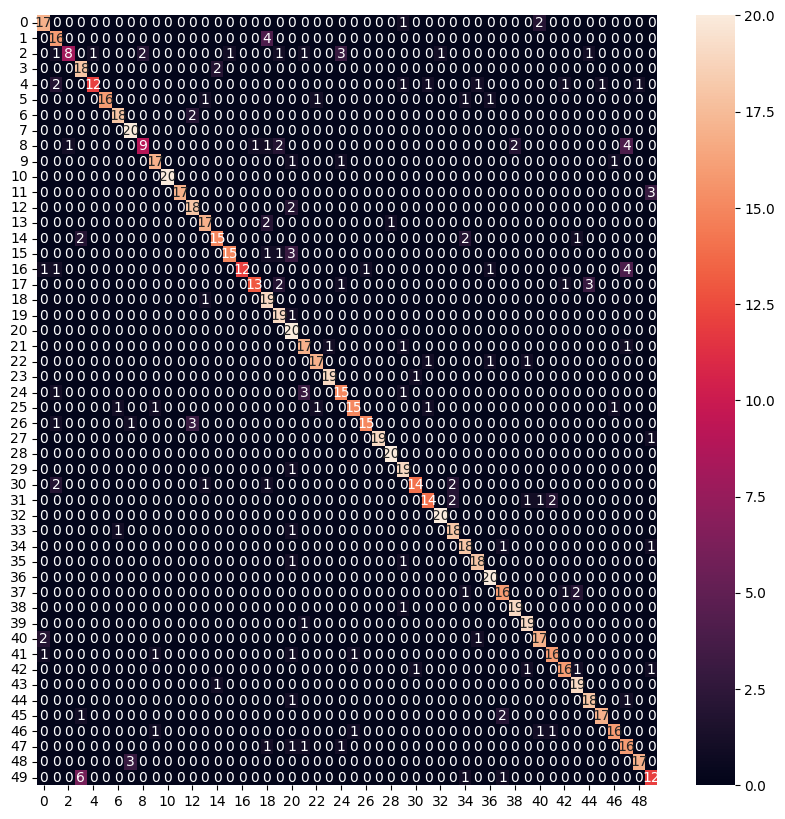

In [55]:
#LSTM
import matplotlib.pyplot as plt
import seaborn as sns

from torch.utils.tensorboard import SummaryWriter
plt.figure(figsize = (10,10))


output_size = 50
hidden_size = 300
vocab_size = len(TEXT.vocab)
embedding_length = 100
word_embeddings = TEXT.vocab.vectors
num_epochs = 1
mode = 'lstm'

model = AuthorClassifier(mode, output_size, hidden_size, vocab_size, embedding_length, word_embeddings)
model.load_state_dict(torch.load("./data/baseline.pt"))
model = model.to(device)
# print(len(word_embeddings), len(TEXT.vocab.itos))
# print(len(word_embeddings[0]))
# print(len(TEXT.vocab))
# vocab_dict = TEXT.vocab.stoi
# vocab_list = TEXT.vocab.itos
# print(vocab_dict["thursday"])


loss_function = nn.CrossEntropyLoss()

# optimizer = torch.optim.Adam(model.parameters(), lr=1e-2)
# log_dir = 'runs/lstm1'
# final_acc_train_lstm  = []
# final_loss_train_lstm = []
# final_loss_test_lstm = []
# final_acc_test_lstm = []
# final_f1score_train_lstm = []
# final_f1score_test_lstm = []


# for multi in range(20):
#   loss_train,f1score,accs = train_classifier(model, train_iterator, loss_function, optimizer, log = log_dir, num_epochs = num_epochs)
#   overall_pred,overall_label,accs_test,f1ss,loss_test = evaluate_classifier(model, val_iterator, loss_function)
#   final_acc_train_lstm.append(accs[0])
#   final_acc_test_lstm.append(accs_test[0])
#   final_f1score_train_lstm.append(f1score[0])
#   final_f1score_test_lstm.append(f1ss)
#   final_loss_train_lstm.append(loss_train[0])
#   final_loss_test_lstm.append(loss_test[0])

overall_pred,overall_label,accs_test,f1ss,loss_test = evaluate_classifier(model, attack_iterator, loss_function)
# torch.save(model.state_dict(), "/content/drive/MyDrive/Deep-Learning-based-Authorship-Identification/data/baseline.pt")

cf = np.zeros((50,50))

overall_pred = [val for sublist in overall_pred for val in sublist]

overall_label = [val for sublist in overall_label for val in sublist]

ziplist = list(zip(overall_label,overall_pred))
for coordinate in ziplist:
  cf[coordinate]+=1
ax = sns.heatmap(cf,annot=True)

In [ ]:
print(auth_sort[6])

DarrenSchuettler


In [13]:
n = len(attack_iterator)
avg_sim = 0

for i in range(n):
    avg_sim += similarity_cal(" ".join(val_iterator.data()[i].text), " ".join(attack_iterator.data()[i].text))
    
avg_sim /= n

print(avg_sim)

0.4237763471901417


In [ ]:
"""
This part is to find top 5 closest words of a certain word.
We use euclidean distance in word embedding to calculate.
"""
words_in_article = []
for info in train.examples[0].text:   # train.examples[0].text is the input article
  words_in_article.append(vocab_dict[info])

words_in_article = torch.tensor(words_in_article, dtype=torch.int64)
output = model.embedding(words_in_article)
np_word_dict = {}

# create dictionary of word-embedding pair of np.array of embeddings
for i in range(len(output)):
  # print(tmp[i])
  # print(vocab_list[tmp[i]])
  # print(output[i])
  li = [float(num) for num in output[i]]
  # print(li, len(li))
  np_word_dict[vocab_list[words_in_article[i]]] = np.array(li)

# print(np_word_dict)

In [ ]:
# calculate closest word by euclidean distance in word embedding
def find_closest_embeddings(embedding):
    return sorted(np_word_dict.keys(), key=lambda word: spatial.distance.euclidean(np_word_dict[word], embedding))

alternatives = []

for retired in to_replace:
  alternatives.append(find_closest_embeddings(np_word_dict[retired])[1:6])  # [1:6] is because [0] will always be itself

print(alternatives)

[['(', '.', ',', 'is', 'also'], ['last', 'one', 'over', ',', 'with'], ['<unk>', '\n', ' \n', 'exception', '898'], [')', ',', '.', 'or', 'from'], ['\n', '8312', '<unk>', ' \n', 'respectively']]


GRU

In [ ]:
#GRU
import matplotlib.pyplot as plt
import seaborn as sns

from torch.utils.tensorboard import SummaryWriter
plt.figure(figsize = (10,10))



output_size = 50
hidden_size = 300
vocab_size = len(TEXT.vocab)
embedding_length = 100
word_embeddings = TEXT.vocab.vectors
num_epochs = 1
mode = 'gru'

model = AuthorClassifier(mode, output_size, hidden_size, vocab_size, embedding_length, word_embeddings)
model = model.to(device)


loss_function = nn.CrossEntropyLoss()

optimizer = torch.optim.Adam(model.parameters(), lr=1e-2)
log_dir = 'runs/gru'
final_acc_train_gru  = []
final_acc_test_gru = []
final_f1score_train_gru = []
final_f1score_test_gru = []
final_loss_train_gru = []
final_loss_test_gru = []

for multi in range(20):
  loss_train,f1score,accs = train_classifier(model, train_iterator, loss_function, optimizer, log = log_dir, num_epochs = num_epochs)
  overall_pred,overall_label,accs_test,f1ss,loss_test = evaluate_classifier(model, val_iterator, loss_function)
  final_acc_train_gru.append(accs[0])
  final_loss_train_gru.append(loss_train[0])
  final_acc_test_gru.append(accs_test[0])
  final_f1score_train_gru.append(f1score[0])
  final_f1score_test_gru.append(f1ss)
  final_loss_test_gru.append(loss_test[0])


cf = np.zeros((50,50))

overall_pred = [val for sublist in overall_pred for val in sublist]

overall_label = [val for sublist in overall_label for val in sublist]

ziplist = list(zip(overall_label,overall_pred))
for coordinate in ziplist:
  cf[coordinate]+=1
ax = sns.heatmap(cf,annot=True)

BiLSTM

In [ ]:
#bilstm
import matplotlib.pyplot as plt
import seaborn as sns

from torch.utils.tensorboard import SummaryWriter
plt.figure(figsize = (10,10))



output_size = 50
hidden_size = 300
vocab_size = len(TEXT.vocab)
embedding_length = 100
word_embeddings = TEXT.vocab.vectors
num_epochs = 1
mode = 'bilstm'

model = AuthorClassifier(mode, output_size, hidden_size, vocab_size, embedding_length, word_embeddings)
model = model.to(device)


loss_function = nn.CrossEntropyLoss()

optimizer = torch.optim.Adam(model.parameters(), lr=1e-2)
log_dir = 'runs/bilstm'
final_acc_train_bilstm  = []
final_acc_test_bilstm = []
final_f1score_train_bilstm = []
final_f1score_test_bilstm = []
final_loss_train_bilstm = []
final_loss_test_bilstm = []

for multi in range(20):
  loss_train,f1score,accs = train_classifier(model, train_iterator, loss_function, optimizer, log = log_dir, num_epochs = num_epochs)
  overall_pred,overall_label,accs_test,f1ss,loss_test = evaluate_classifier(model, val_iterator, loss_function)
  final_acc_train_bilstm.append(accs[0])
  final_loss_train_bilstm.append(loss_train[0])
  final_acc_test_bilstm.append(accs_test[0])
  final_f1score_train_bilstm.append(f1score[0])
  final_f1score_test_bilstm.append(f1ss)
  final_loss_test_bilstm.append(loss_test[0])


cf = np.zeros((50,50))

overall_pred = [val for sublist in overall_pred for val in sublist]

overall_label = [val for sublist in overall_label for val in sublist]

ziplist = list(zip(overall_label,overall_pred))
for coordinate in ziplist:
  cf[coordinate]+=1
ax = sns.heatmap(cf,annot=True)

Plot - Accuracy

In [ ]:
#Plot - accuracy
import plotly.graph_objects as go
fig_accuracy = go.Figure()

fig_accuracy.add_trace(go.Scatter(
    y=final_acc_train_lstm,
    connectgaps=True, marker_color='rgba(128, 0, 0, 0.9)', name = 'Training accuracy lstm'))

fig_accuracy.add_trace(go.Scatter(
    y=final_acc_test_lstm,
    connectgaps=True, marker_color='rgba(255, 0, 0, 0.9)', name = 'Testing accuracy lstm'))

fig_accuracy.add_trace(go.Scatter(
    y=final_acc_train_gru,
    connectgaps=True, marker_color='rgba(0, 128, 0, 0.9)', name = 'Training accuracy gru'))
fig_accuracy.add_trace(go.Scatter(
    y=final_acc_test_gru,
    connectgaps=True, marker_color = 'rgba(0, 255, 0, 0.9)', name = 'Testing accuracy gru'))

fig_accuracy.add_trace(go.Scatter(
    y=final_acc_train_bilstm,
    connectgaps=True, marker_color='rgba(0, 0, 128, 0.9)', name = 'Training accuracy bilstm'))
fig_accuracy.add_trace(go.Scatter(
    y=final_acc_test_bilstm, connectgaps=True, marker_color='rgba(0, 0, 255, 0.9)',
    name='Test accuracy bilstm'))

fig_accuracy.show()

Loss Plots

In [ ]:
#Loss Plots
import plotly.graph_objects as go
fig_loss = go.Figure()

fig_loss.add_trace(go.Scatter(
    y=final_loss_train_lstm,
    connectgaps=True, marker_color='rgba(128, 0, 0, 0.9)', name = 'Training Loss lstm'))

fig_loss.add_trace(go.Scatter(
    y=final_loss_test_lstm,
    connectgaps=True, marker_color='rgba(255, 0, 0, 0.9)', name = 'Testing Loss lstm'))

fig_loss.add_trace(go.Scatter(
    y=final_loss_train_gru,
    connectgaps=True, marker_color='rgba(0, 128, 0, 0.9)', name = 'Training Loss gru'))

fig_loss.add_trace(go.Scatter(
    y=final_loss_test_gru,
    connectgaps=True, marker_color='rgba(0, 255, 0, 0.9)', name = 'Testing Loss gru'))

fig_loss.add_trace(go.Scatter(
    y=final_loss_train_bilstm,
    connectgaps=True, marker_color='rgba(0, 0, 128, 0.9)', name = 'Training Loss bilstm'))

fig_loss.add_trace(go.Scatter(
    y=final_loss_test_bilstm,
    connectgaps=True, marker_color='rgba(0, 0, 255, 0.9)', name = 'Testing Loss bilstm'))

fig_loss.show()

F1 Score plots

In [ ]:
#Plot - f1score
import plotly.graph_objects as go
fig_f1score = go.Figure()

fig_f1score.add_trace(go.Scatter(
    y=final_f1score_train_lstm,
    connectgaps=True, marker_color='rgba(128, 0, 0, 0.9)', name = 'Training f1score lstm'))

fig_f1score.add_trace(go.Scatter(
    y=final_f1score_test_lstm,
    connectgaps=True, marker_color='rgba(255, 0, 0, 0.9)', name = 'Testing f1score lstm'))

fig_f1score.add_trace(go.Scatter(
    y=final_f1score_train_gru,
    connectgaps=True, marker_color='rgba(0, 128, 0, 0.9)', name = 'Training f1score gru'))
fig_f1score.add_trace(go.Scatter(
    y=final_f1score_test_gru,
    connectgaps=True, marker_color = 'rgba(0, 255, 0, 0.9)', name = 'Testing f1score gru'))

fig_f1score.add_trace(go.Scatter(
    y=final_f1score_train_bilstm,
    connectgaps=True, marker_color='rgba(0, 0, 128, 0.9)', name = 'Training f1score bilstm'))
fig_f1score.add_trace(go.Scatter(
    y=final_f1score_test_bilstm, connectgaps=True, marker_color='rgba(0, 0, 255, 0.9)',
    name='Test f1score bilstm'))

fig_f1score.show()